In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.run.model_load.load_ssn import load_ssn

# optimizer and lr scheduler
import torch

# misc
import argparse
import os

print("banana")

strawberry
banana


In [2]:
# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
combined_ds = load_clinscores_data()

In [5]:
dataset = combined_ds

### loading the saved predictions

In [6]:
x, y, values = next(iter(dataset))

In [7]:
temp_dir = "/home/s2208943/ipdis/data/preprocessed_data/EdData_preds/"

In [8]:
fs = os.listdir(temp_dir)[0]
l = torch.from_numpy(np.load(temp_dir + values['ID'] + "_mean.npz")['arr_0'])

In [9]:
y.shape

torch.Size([1, 40, 224, 160])

In [10]:
means = []
ent_maps = []
clin_values_list = []
xs = []
ys = []
idx_to_id_map = {}

for i, (x, y, values) in enumerate(tqdm(dataset, position=0, leave=True)):
    ID = values['ID']
    mean = torch.from_numpy(np.load(temp_dir + values['ID'] + "_mean.npz")['arr_0'])
    umap = torch.from_numpy(np.load(temp_dir + values['ID'] + "_umap.npz")['arr_0'])
    xs.append(x)
    ys.append(y)
    idx_to_id_map[ID] = i
    
    means.append(mean)
    ent_maps.append(umap)
    clin_values_list.append(values)

clin_values = pd.DataFrame.from_records(clin_values_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 27.65it/s]


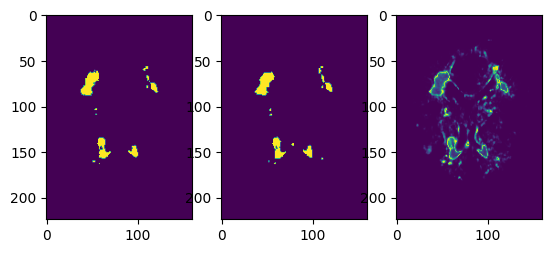

In [11]:
scan_id = 4
x, y, values = dataset[scan_id]

plt.subplot(1, 3, 1)
plt.imshow(y[0][20])
plt.subplot(1, 3, 2)
plt.imshow(means[scan_id][20].argmax(dim=0))
plt.subplot(1,3,3)
plt.imshow(ent_maps[scan_id][20])

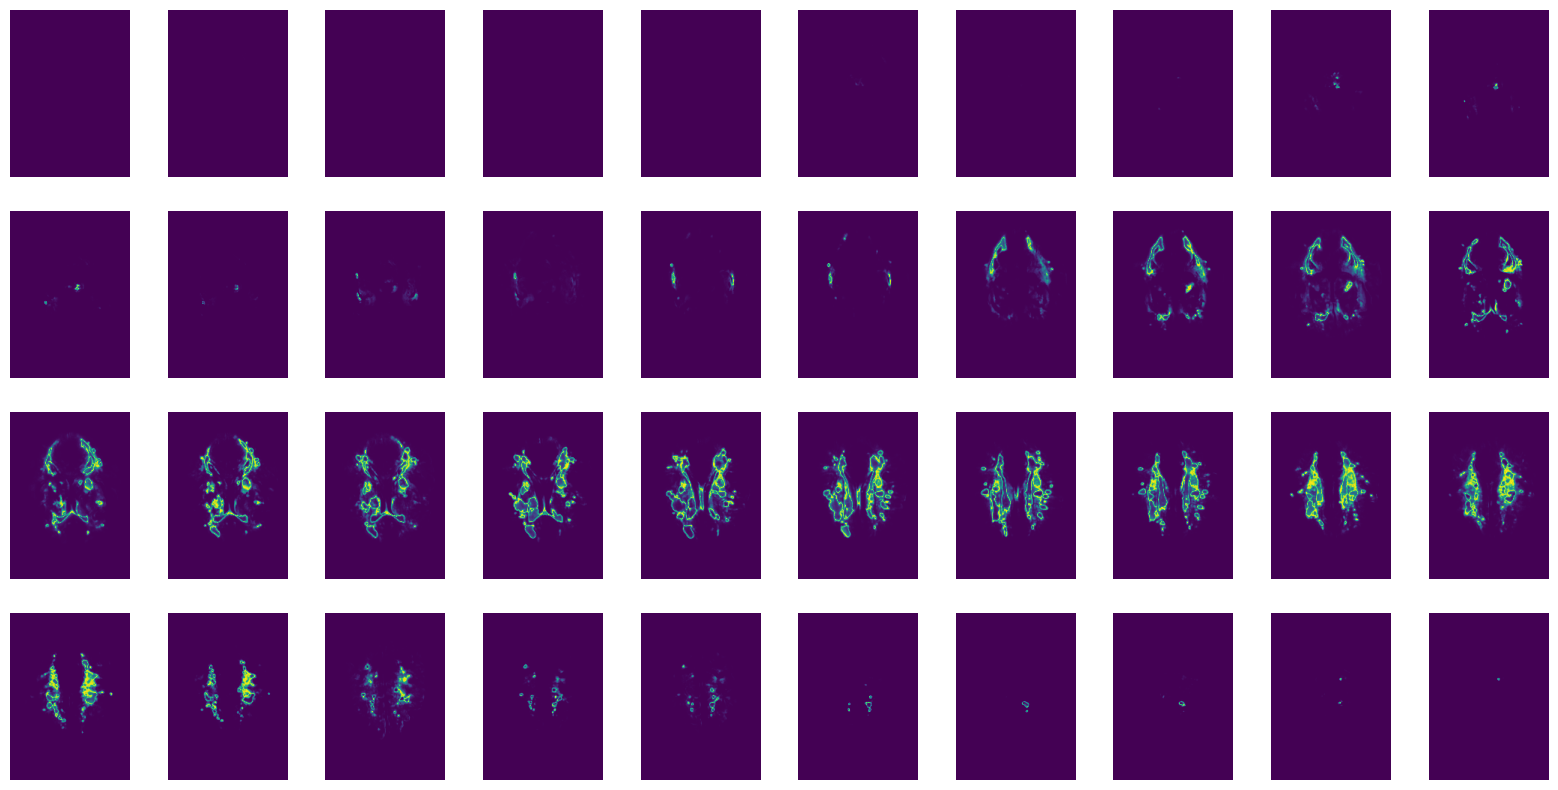

In [12]:
# plot the entropy map for the first brain scan all slices
plt.figure(figsize=(20, 10))
for i, img in enumerate(ent_maps[0]):
    plt.subplot(4, 10, i+1)
    plt.imshow(img, vmin=0, vmax=0.7)
    plt.axis('off')

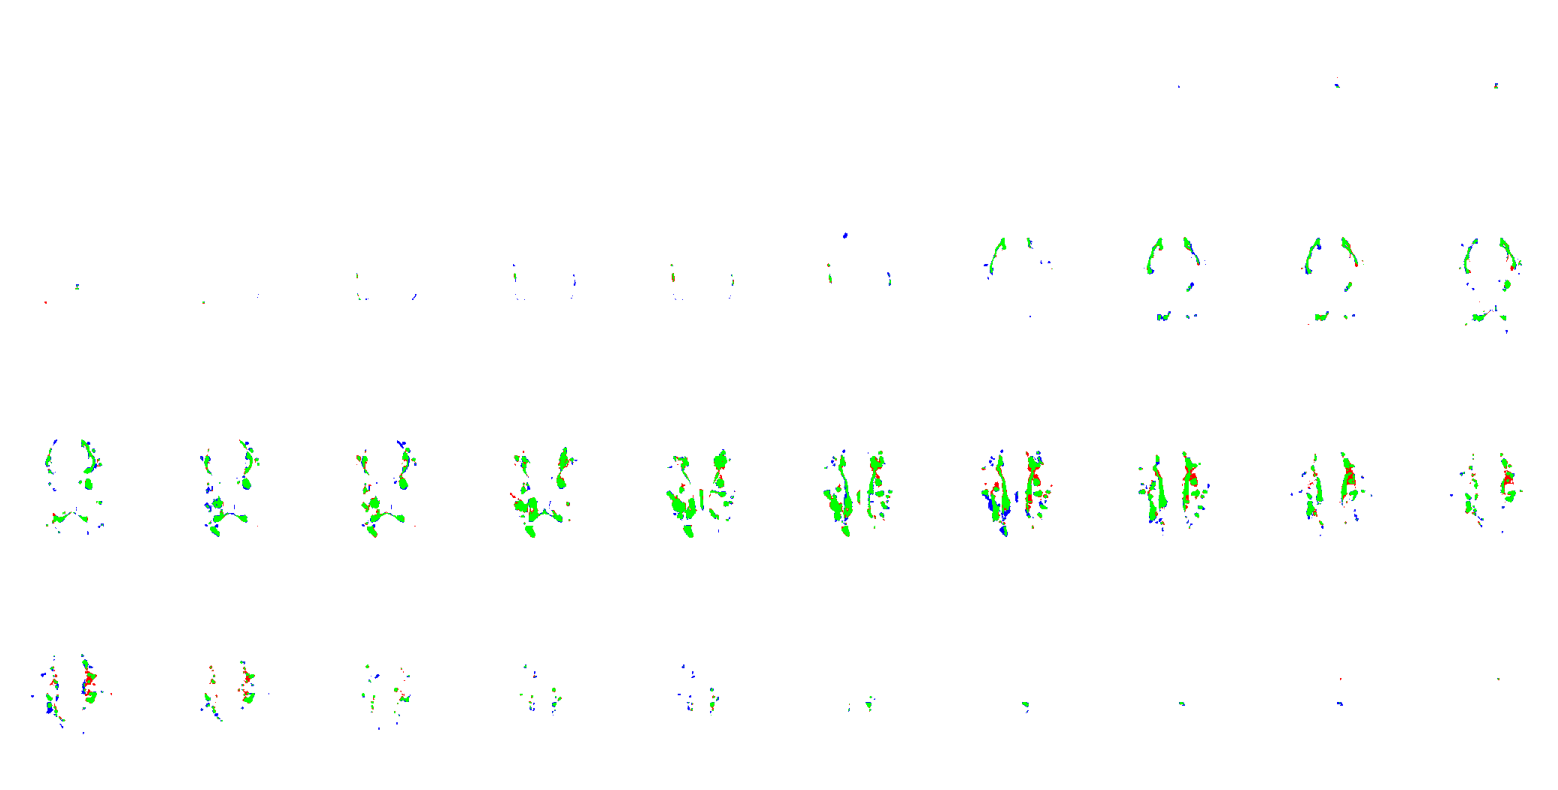

In [13]:
def image_prediction_type_image(target_slice, pred_slice, background_colour='white'):
    tp = target_slice * pred_slice
    fp = (1-target_slice) * pred_slice
    fn = target_slice * (1-pred_slice)
    
    out_image = torch.zeros((*target_slice.shape, 3))

    if background_colour == 'white':
        # # version on white background
        fn = fn.type(torch.bool)
        tp = tp.type(torch.bool)
        fp = fp.type(torch.bool)
        out_image[:,:,:] = 1
        out_image[:,:,1] = 1 - (fn | fp).type(torch.float32)
        out_image[:,:,0] = 1 - (tp | fn).type(torch.float32)
        out_image[:,:,2] = 1 - (tp | fp).type(torch.float32)
        
    else:
        # simple version on black background
        out_image[:,:,1] = tp
        out_image[:,:,0] = fp
        out_image[:,:,2] = fn
        
    return out_image
        
    
# plot the mean segmentation
plt.figure(figsize=(20, 10))
target = dataset[0][1][0]
for i, pred_slice in enumerate(means[0].argmax(dim=1)):
    target_slice = target[i]
    
    out_image = image_prediction_type_image(
        target_slice,
        pred_slice,
        background_colour='white'
    )
    
    plt.subplot(4, 10, i+1)
    plt.imshow(out_image)
    plt.axis('off')

In [14]:
selected = torch.randint(250, (20,))

In [15]:
means[0].shape

torch.Size([40, 2, 224, 160])

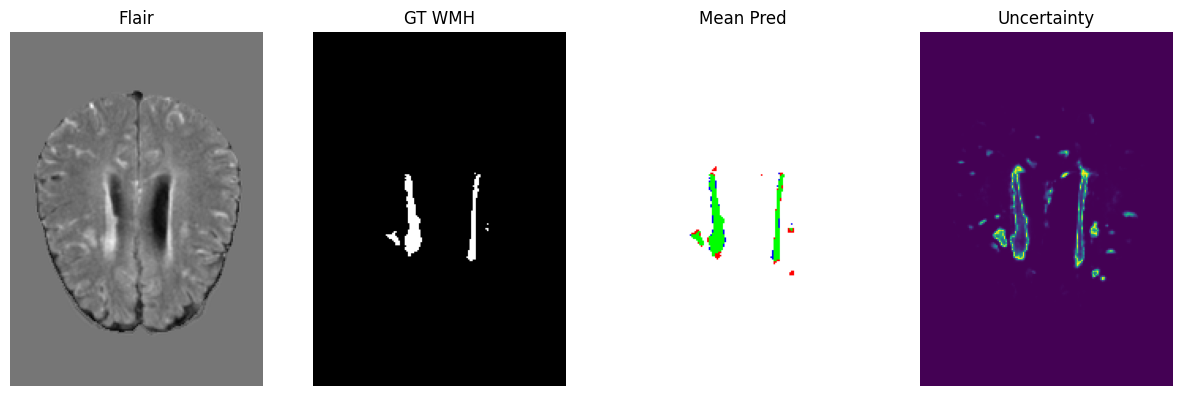

In [16]:
def plot_subimg(img, rows, cols, i, cmap='gray', axis='off', title='', vmin=None, vmax=None):
    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis(axis)
    plt.title(title)
    return i + 1

    
rows = 1
cols = 4
i = 1

plt.figure(figsize=(15, 5))
scan_id = 8
slice_id = 25
i = plot_subimg(dataset[scan_id][0][0][slice_id], rows=rows, cols=cols, i=i, title='Flair')
i = plot_subimg(dataset[scan_id][1][0][slice_id], rows=rows, cols=cols, i=i, title='GT WMH')
i = plot_subimg(image_prediction_type_image(dataset[scan_id][1][0][slice_id], means[scan_id][slice_id].argmax(dim=0)), rows=rows, cols=cols, i=i, title='Mean Pred', cmap=None)
i = plot_subimg(ent_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, cmap=None, title='Uncertainty')

plt.savefig("datatypes.png")

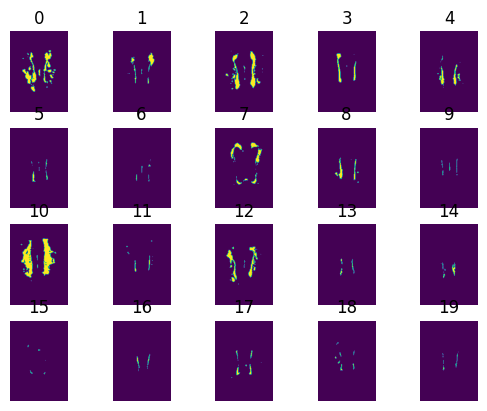

In [17]:
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(means[i].argmax(dim=1)[25])
    plt.axis('off')
    plt.title(i)

In [18]:
def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def dice_loss_old(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    return torch.mean(combined)

In [19]:
individual_dice(means[0], dataset[0][1][0])

tensor([0.0035, 0.0028, 0.0023, 0.0028, 0.0026, 0.0027, 0.0027, 0.8344, 0.5469,
        0.4153, 0.4617, 0.4093, 0.4958, 0.5642, 0.3763, 0.4453, 0.2358, 0.2371,
        0.2164, 0.2362, 0.2298, 0.2324, 0.2157, 0.1696, 0.1472, 0.1694, 0.2655,
        0.1995, 0.2328, 0.2650, 0.3810, 0.3347, 0.3176, 0.3254, 0.4327, 0.1646,
        0.1733, 0.2312, 0.7885, 0.2931])

In [20]:
dice_loss(means[0], dataset[0][1][0])

tensor(0.3028)

In [21]:
clin_values

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,WMH,PVWMH,DWMH,deepAtrophy,supAtrophy,BGPVS,CSPVS,relLes,oldLes,micrBld
0,4,CVD008,1,50.0,2,0,1,0.0,2.0,196.0,...,56.672922,2.0,3.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0
1,9,CVD014,1,74.0,1,0,1,0.0,0.0,138.0,...,19.852734,1.0,1.0,0.0,2.0,1.0,3.0,1.0,1.0,0.0
2,10,CVD016,1,87.0,1,0,1,0.0,0.0,165.0,...,77.187691,3.0,3.0,4.0,2.0,3.0,1.0,1.0,1.0,14.0
3,12,CVD018,1,77.0,2,0,1,1.0,0.0,179.0,...,28.363308,2.0,1.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0
4,16,CVD023,1,74.0,1,1,1,0.0,1.0,123.0,...,22.021616,3.0,2.0,4.0,4.0,3.0,2.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,CVD321,1,64.0,1,0,1,1.0,0.0,144.0,...,32.568750,3.0,1.0,3.0,2.0,1.0,2.0,1.0,1.0,0.0
246,246,CVD322,1,50.0,2,0,1,1.0,2.0,123.0,...,0.189844,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
247,247,CVD323,1,63.0,1,0,1,1.0,0.0,112.0,...,18.000000,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0
248,248,CVD324,1,63.0,1,0,1,1.0,0.0,170.0,...,33.626953,1.0,3.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0


### TODO next
- build the cin_values back into a pandas df
- decide how to deal with nans for each example (find where the empty string field is and check that there is nothing dodgy going on - e.g rows haven't been displaced by one or something, sanity check the data)
- deicde what metrics I want to compute (e.g Uncertainty vs WMH diff (e.g the uncertainty in areas other than the mean segmentation), uncertainty mass, uncertainty VVC, uncertainty / WMH volume, etc
- think are there other ways of generating the uncertianty map from the samples (now would be a good time to evaluate variance, kernel density estimation etc instead of just mean uncertainty maps)
- do a PCA on the uncertainty metrics I compute, see what parameters explain the uncertainty volume for example
- do some general linear modelling to explain each parameter with and without uncertainty map, see what is useful
- try to say adjust for stroke or whichever factors are important in PCA and see if that accounts for volume difference where the mean prediction is far away from the rest
- look up the paper and email maria sent a long time ago with the other analysis that I need to do.


### Looking at Nan values

In [22]:
for key in clin_values.keys():
    vs = clin_values[key].values
    try:
        nans = np.isnan(vs).sum()
    except:
        nans = 'unknown'
    try:
        uniques = np.unique(vs)
        if len(uniques) < 20:
            print(key, ": ", uniques, ", num nans: ", nans)
        else:
            print(key, ", num nans: ", nans)
    except:
        print(key, " causes problems due to string value" , ", num nans: ", nans)

Unnamed: 0 , num nans:  0
ID , num nans:  unknown
sbjGroup :  [0 1 2] , num nans:  0
age , num nans:  0
sex :  [1 2] , num nans:  0
diabetes :  [0 1] , num nans:  0
hypertension :  [0 1] , num nans:  0
hyperlipidaemia :  [ 0.  1. nan] , num nans:  3
smoking :  [ 0.  1.  2. nan] , num nans:  1
SBP , num nans:  7
DBP , num nans:  7
totalChl  causes problems due to string value , num nans:  unknown
MMSE :  [21. 22. 23. 24. 25. 26. 27. 28. 29. 30. nan] , num nans:  106
ICV , num nans:  2
WMH , num nans:  0
PVWMH :  [ 0.  1.  2.  3. nan] , num nans:  26
DWMH :  [ 0.  1.  2.  3. nan] , num nans:  26
deepAtrophy :  [ 0.  1.  2.  3.  4.  5.  6. nan] , num nans:  26
supAtrophy :  [ 0.  1.  2.  3.  4.  5.  6. nan] , num nans:  26
BGPVS :  [ 0.  1.  2.  3.  4.  5.  6. nan] , num nans:  26
CSPVS :  [ 0.  1.  2.  3.  4.  5. nan] , num nans:  26
relLes :  [ 0.  1. nan] , num nans:  88
oldLes :  [ 0.  1. nan] , num nans:  26
micrBld :  [ 0.  1.  2.  3.  4.  5.  7.  8. 11. 13. 14. 15. 20. 28. nan] , n

In [23]:
#np.isnan(clin_values['totalChl'].values[0:57].astype(np.float32)).sum() + np.isnan(clin_values['totalChl'].values[58:].astype(np.float32)).sum()

In [24]:
np.where(np.isnan(clin_values['hyperlipidaemia']))

(array([54, 56, 63]),)

In [25]:
clin_values.iloc[45:55][['sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'micrBld']]

,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,DBP,totalChl,MMSE,deepAtrophy,supAtrophy,BGPVS,CSPVS,micrBld
45,1,74.0,1,0,1,0.0,1.0,220.0,110.0,7.4,NaN,4.0,4.0,3.0,3.0,1.0
46,1,63.0,1,0,0,1.0,2.0,160.0,80.0,3.7,NaN,4.0,0.0,0.0,1.0,0.0
47,1,71.0,1,0,1,1.0,2.0,128.0,66.0,4.8,NaN,6.0,6.0,2.0,1.0,0.0
48,1,74.0,1,1,1,1.0,1.0,142.0,82.0,3.5,NaN,4.0,2.0,3.0,2.0,0.0
49,1,49.0,1,0,0,1.0,1.0,135.0,97.0,7.3,NaN,0.0,2.0,1.0,1.0,0.0
50,1,68.0,2,0,1,1.0,0.0,129.0,78.0,6,NaN,2.0,2.0,2.0,3.0,0.0
51,2,53.0,1,0,0,1.0,1.0,125.0,80.0,3.4,NaN,NaN,NaN,NaN,NaN,NaN
52,2,76.0,2,1,1,1.0,2.0,187.0,94.0,6.6,NaN,NaN,NaN,NaN,NaN,NaN
53,2,58.0,1,0,1,0.0,2.0,135.0,82.0,2.9,NaN,NaN,NaN,NaN,NaN,NaN
54,2,80.0,2,0,0,NaN,1.0,150.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
clin_values

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,WMH,PVWMH,DWMH,deepAtrophy,supAtrophy,BGPVS,CSPVS,relLes,oldLes,micrBld
0,4,CVD008,1,50.0,2,0,1,0.0,2.0,196.0,...,56.672922,2.0,3.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0
1,9,CVD014,1,74.0,1,0,1,0.0,0.0,138.0,...,19.852734,1.0,1.0,0.0,2.0,1.0,3.0,1.0,1.0,0.0
2,10,CVD016,1,87.0,1,0,1,0.0,0.0,165.0,...,77.187691,3.0,3.0,4.0,2.0,3.0,1.0,1.0,1.0,14.0
3,12,CVD018,1,77.0,2,0,1,1.0,0.0,179.0,...,28.363308,2.0,1.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0
4,16,CVD023,1,74.0,1,1,1,0.0,1.0,123.0,...,22.021616,3.0,2.0,4.0,4.0,3.0,2.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,CVD321,1,64.0,1,0,1,1.0,0.0,144.0,...,32.568750,3.0,1.0,3.0,2.0,1.0,2.0,1.0,1.0,0.0
246,246,CVD322,1,50.0,2,0,1,1.0,2.0,123.0,...,0.189844,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
247,247,CVD323,1,63.0,1,0,1,1.0,0.0,112.0,...,18.000000,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0
248,248,CVD324,1,63.0,1,0,1,1.0,0.0,170.0,...,33.626953,1.0,3.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0


In [27]:
clin_values.keys()

Index(['Unnamed: 0', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld'],
      dtype='object')

### Policy on Nans, one hot coding, and choosing columns

**PVWMH, DWMH, deepAtrophy, supAtrophy, BGPVS, CSPVS, oldLes, relLes** all have 20 rows where these are Nan. SO we can do two models with and without these fields

**totalChl** while in the train data it seems to have the same number of nans as the above fields, in the val and test data it is different, so will have to adjust accordingly.

**sbjGroup, age, sex, diabetes, hypertension** all have no Nans.

**hyperlipidaemia**, we cannot be certain about this, high blood pressure on a single instance may imply this but there are other causes so we cannot make a meaningful decision either way.
So, I can use a fill policy, but I should also try removing the row, and removing the column. I can try to look at those with the same smoking prediction and other values to fill it in, but this row is possibly not worth saving.
leave the more intelligent averaging based on say smoking type or age later.

**smoking** we can't fill this in, so remove this row, or remove the smoking column. So I will need mechanisms that only remove a certain row depending on the column value.

**SBP AND DBP** missing for 6 patients (I expect for all 6 the same. Again, either remove these rows or remove the column, (or replace with mean value - but this is frankly sketchy))

**MMSE** 79 missing, a basic test such as who is the prime minister, who is the monarch, a very basic test not very informative (and currently a little unfair given the changes in both)

**relLes** where sbjGroup is 0 can be set to zero (there is no relevant lesion because there is no lesion is my logic)

**NOTE:** sbjGroup is **never** 2 when the brain scores are included, this is a very wierd and specific ommision that I do not understand.

**To Flag with Maria!**
The data where sbjGroup == 2 never contains the 'brain scores' fields, which is frankly quite annoying. There is that nan that has been replaced with empty string, again im concerned
that looks a lot like human error and that someone has been fiddling where they should not.

**note about uncertainty maps used**
ideally, I need to now cross-validate train my uncertainty quantification model and then I can use the predictions across all of the training data.
I should also compare to a deterministic model using its confidence.
and 

looking at this example, I am not sure what the NAWM should be and how to calculate it. But I think its not supposed to be highlighting all the area around the brain but it is supposed to highlight the area that is damaged around the WMH, so we need to filter out those high intensity voxels on the periphery of the image.

so damamge does track with dice but thats because it tracks with volume as well.

### Other uncertainty map metrics
Ideas I have include:
- total uncertainty mass and uncertainty VVC
- thresholded uncertainty mass, or mass of values above a given uncertainty.
- one thing to note is that the uncertianty is low inside the lesion, so we should model uncertainty + mean segmentation, or we shoud look at regions that are uncertain above a threshold orred with the mean segmentation

**NOTE**: alternative approach. Since we would only be comparing uncertianty maps, maybe it doesn't matter that they don't fill in the center of the lesion? uncertainty maps correlate with true volume anyway so maybe it doesn't matter.
so instead we could just use the mass directly.....

In [92]:
# lets just start with total uncertainty mass and wmh mass
uncert_mass = []
wmh_mass = []
mean_mass = []
for i, (x, y, values) in enumerate(tqdm(dataset, position=0, leave=True)):
    uncert_mass.append(ent_maps[i].sum())
    wmh_mass.append(y.sum())
    mean_mass.append(means[i].cuda().argmax(dim=1).sum().cpu())
    
uncert_mass = torch.Tensor(uncert_mass)
wmh_mass = torch.Tensor(wmh_mass)
mean_mass = torch.Tensor(mean_mass)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 206.72it/s]


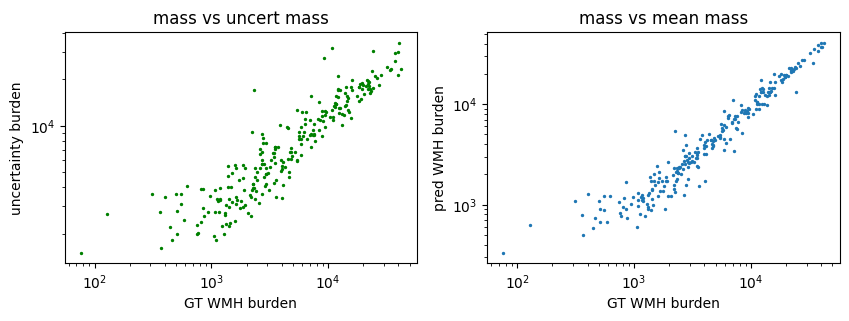

In [93]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.scatter(wmh_mass, uncert_mass, c='g', s=2)
plt.xlabel("GT WMH burden")
plt.ylabel("uncertainty burden")
plt.xscale('log')
plt.yscale('log')
plt.title("mass vs uncert mass")

plt.subplot(1,2,2)
plt.scatter(wmh_mass, mean_mass, s=2)
plt.xlabel("GT WMH burden")
plt.ylabel("pred WMH burden")
plt.xscale('log')
plt.yscale('log')
plt.title("mass vs mean mass");
plt.savefig("mass_and_uncert_burden_vs_GT")

**NOTE**: okay so the mean segmentation mass on the training data is much tighter, lower variance predictor of the target, which we would expect. The uncertainty maps have a greater variance, but the nice thing here is that
actually, we see that the mass is generally predictable from predicting the wmh mass. Now we want to see if the uncertainty variance is predicted by something else.

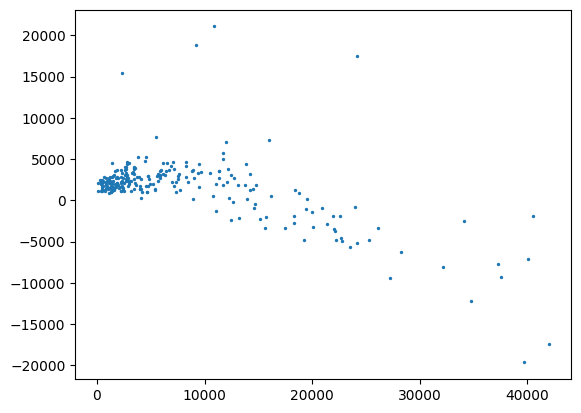

In [94]:
plt.scatter(wmh_mass, uncert_mass - mean_mass, s=2)
# plt.xscale('log')
# plt.yscale('log')

**Note**: so we see that the mean mass can be bigger than the uncertainty mass, and the larger the mass, the more of the lesion that is not edge, and so more of the lesion is less certain, so we need to add the lesion to the uncertainty...

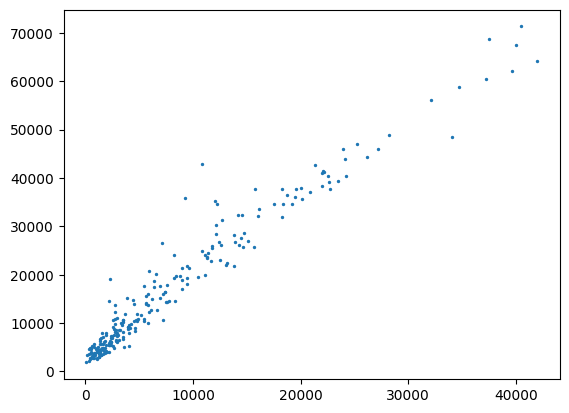

In [95]:
plt.scatter(wmh_mass, uncert_mass + mean_mass, s=2)

**Note**: BUT we can't just add them, together, as again that is just going to be further away when the volume is bigger, the uncertainty is bigger when there is more volume. So, maybe we should use the uncertainty weighted by the total volume in some way

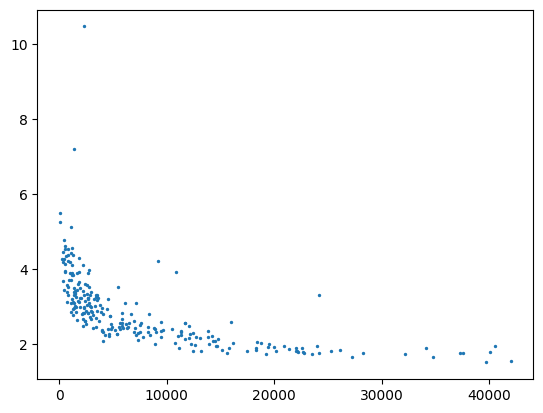

In [96]:
plt.scatter(wmh_mass, (uncert_mass+mean_mass)/(mean_mass), s=2)

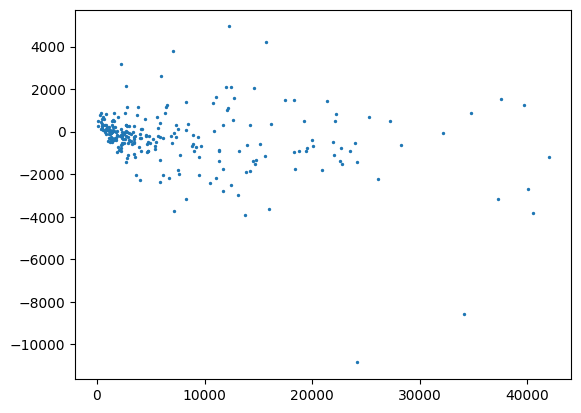

In [97]:
plt.scatter(wmh_mass, mean_mass - wmh_mass, s=2)
# plt.xscale('log')
# plt.yscale('log')

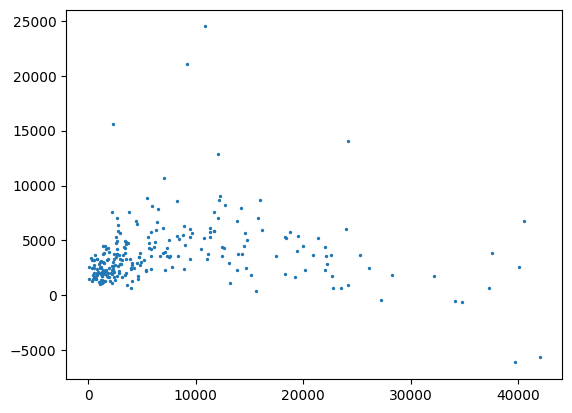

In [115]:
plt.scatter(wmh_mass, uncert_mass - (wmh_mass * 0.69), s=2)

**Note**: but again with this ratio, we have a bias, now bias the low volumes, we see that for low volumes we would be massively overestimating the damage

### uncertainty orred with wmh mean * max ent
given the plots above, we need to be careful about how we are using the uncertianty maps.
we can try orring with (uncert map) | (wmh segmentation * ~0.7) and then plot this - wmh gt * 0.7 see what kind of line we get.
or just use the uncertianty maps as is

remember to focus on what maria wants, e.g does higher volume than in the prediction suggest identifying where there is stroke, or some other variable

try PCA on all teh variables + my uncertainty metric when I get it.

In [99]:
import math
max_ent = -math.log(0.5)
max_ent

0.6931471805599453

In [100]:
dmg_maps = []
for i in tqdm(range(len(ent_maps)), position=0, leave=True):
    umap = ent_maps[i].cuda().clone()
    umap[means[i].cuda().argmax(dim=1) == 1] = max_ent
    dmg_maps.append(umap.cpu())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 87.17it/s]


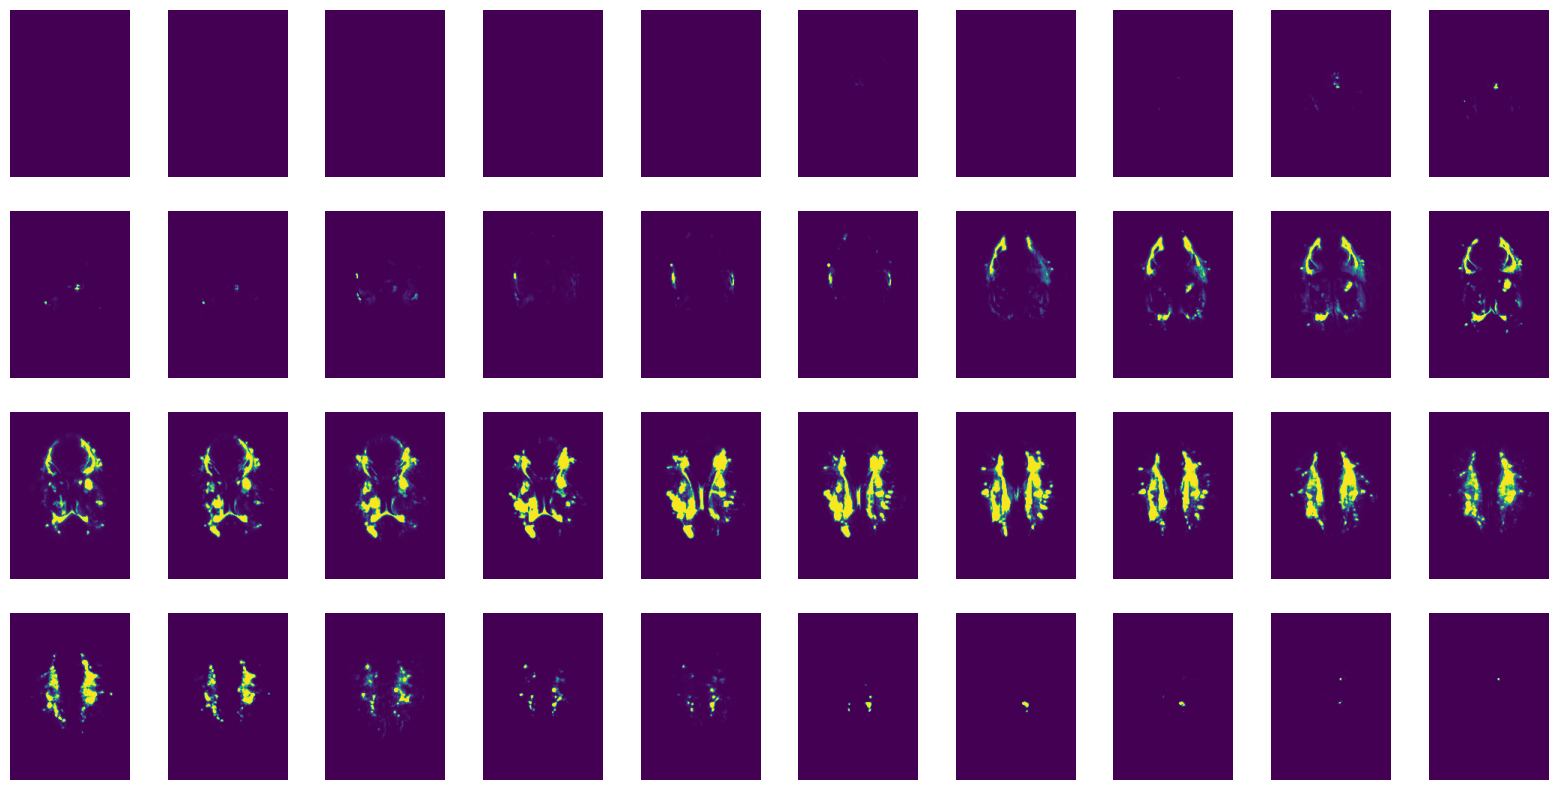

In [101]:
# plot the entropy map for the first brain scan all slices
plt.figure(figsize=(20, 10))
for i, img in enumerate(dmg_maps[0]):
    plt.subplot(4, 10, i+1)
    plt.imshow(img, vmin=0, vmax=0.7)
    plt.axis('off')

In [102]:
rows = 1
cols = 4
i = 1

plt.figure(figsize=(15, 5))
scan_id = 8
slice_id = 25
i = plot_subimg(dataset[scan_id][0][0][slice_id], rows=rows, cols=cols, i=i, title='Flair')
i = plot_subimg(means[scan_id][slice_id].argmax(dim=0), rows=rows, cols=cols, i=i, title='Mean Pred')
i = plot_subimg(ent_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, cmap=None, title='Uncertainty')
i = plot_subimg(dmg_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, cmap=None, title='Damage Map')


plt.savefig("damage_map.png")

NameError: name 'plot_subimg' is not defined

<Figure size 1500x500 with 0 Axes>

In [103]:
# lets just start with total uncertainty mass and wmh mass
dmg_mass = []
mean_dmg_mass = []
for i, (x, y, values) in enumerate(tqdm(dataset, position=0, leave=True)):
    # compute sum where we give the mean pred maximum entropy
    dmg_mass.append(dmg_maps[i].cuda().sum().cpu().item())
    mean_dmg_mass.append(mean_mass[i] * max_ent)
    
    
dmg_mass = torch.Tensor(dmg_mass)
mean_dmg_mass = torch.Tensor(mean_dmg_mass)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 604.23it/s]


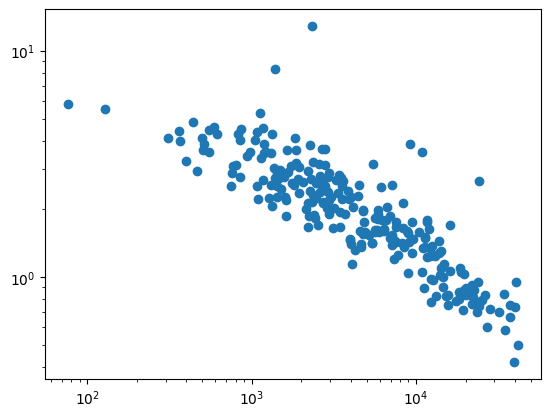

In [104]:
plt.scatter(wmh_mass, (dmg_mass - mean_dmg_mass)/mean_dmg_mass)
plt.yscale('log')
plt.xscale('log')

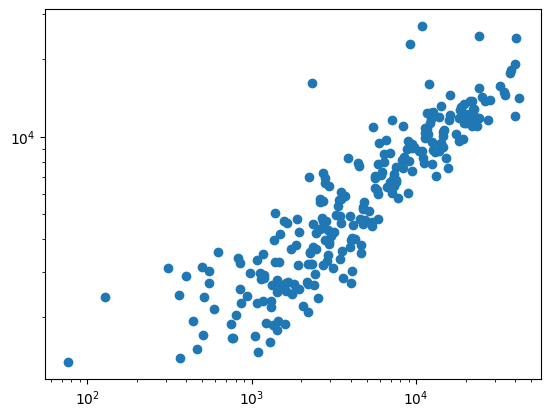

In [105]:
plt.scatter(wmh_mass, (dmg_mass - mean_dmg_mass))
plt.yscale('log')
plt.xscale('log')

In [106]:
pred = means[0].cuda().clone().argmax(dim=1).unsqueeze(1).type(torch.float32)
pred.shape 

torch.Size([40, 1, 224, 160])

### Computing umap metrics relative to surface area

In [107]:
class BinaryEdgeDetector2d():
    def __init__(self):
        l = torch.nn.Conv2d(1, 2, kernel_size=3, bias=False, padding=1)
        k = torch.Tensor([-1,-2,-1,0,0,0,1,2,1]).reshape((3, 3)).T
        l.weight.data[0][0] = k
        l.weight.data[1][0] = (k*-1).T
        l = l.cuda()
        self.l = l
        
    def __call__(self, x):
        x = x.cuda()
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        if x.shape[1] > 1:
            raise ValueError("edge detector expects a 1 channel binary mask")
        x = x.type(torch.float32)
        
        with torch.no_grad():
            edge = self.l(x)
            edge = edge.abs()
            edge = (edge[:,0] > 0) | (edge[:,1] > 0)
            edge = edge.cpu()
            return edge

In [108]:
edge_detector = BinaryEdgeDetector2d()
surface_area = []
for m in tqdm(means, position=0, leave=True):
    surface_area.append(edge_detector(m.cuda().argmax(dim=1)).sum().cpu().item())
    
surface_area = torch.Tensor(surface_area)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 107.88it/s]


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/matplotlib/collections.py:1084: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


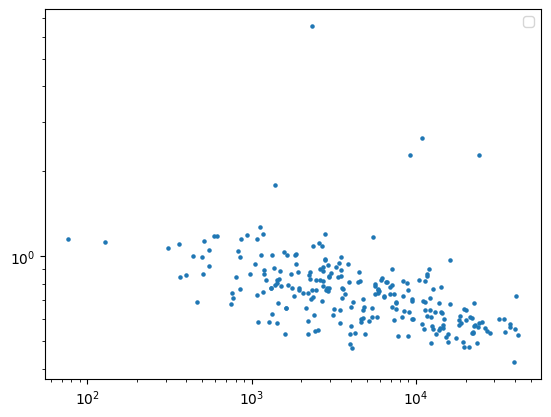

In [109]:
color = None#clin_values['sbjGroup'].values
scatter = plt.scatter(wmh_mass, (dmg_mass - mean_dmg_mass)/surface_area, c=color, label=color, s=5)
plt.yscale('log')
plt.xscale('log')
plt.legend(*scatter.legend_elements())


In [110]:
len(dmg_mass)

250

In [111]:
clin_values['sbjGroup'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

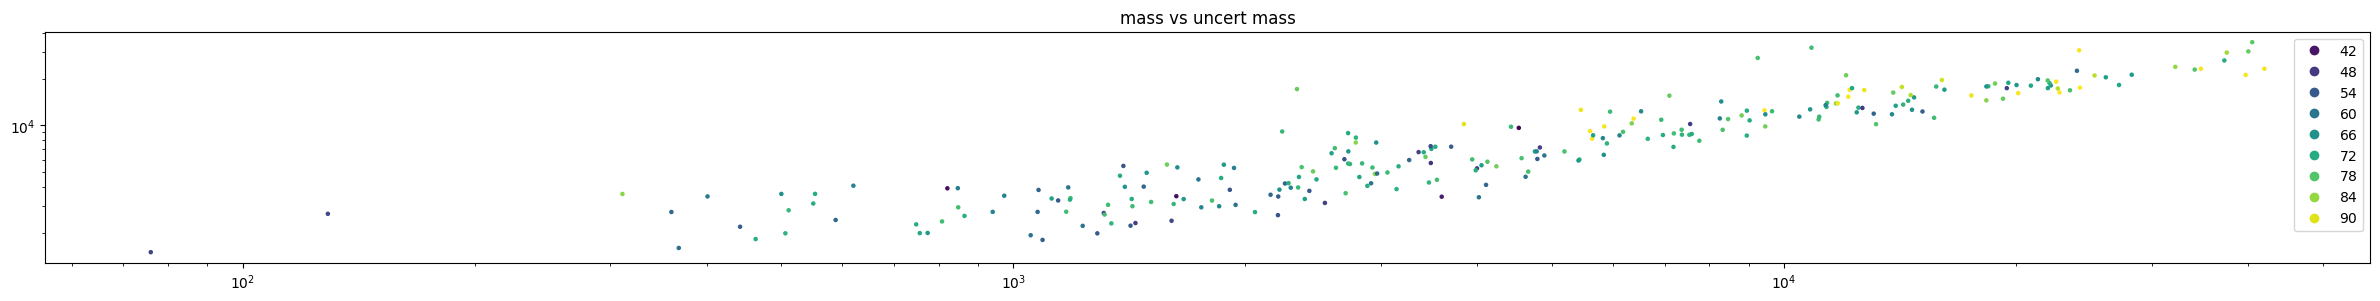

In [112]:
plt.figure(figsize=(30, 3))
color = clin_values['age'].values
scatter = plt.scatter(wmh_mass, uncert_mass, c=color, s=5, label=color)
plt.xscale('log')
plt.yscale('log')
plt.title("mass vs uncert mass")
plt.legend(*scatter.legend_elements())

### Considering the slice by slice effect
The increase in uncertainty at a specific slice / set of slices may be overshadowed by the overall volume
so instead, I could look at per-slice behaviour?
I could look at the distribution over the slices of ratio of dmg to the mean or surface area...
or I could store the maximum difference per slice, this could be an interesting analysis... (then you would likely capture the highest uncertainty at the slice where the
stroke lesion is most present...)

**NOTE**: also, remembre the image (in val set) where the model segments a 'hook' shape in the top right hand side, but misses much of the lesion on both sides middle of the brain. There is an image like this in the validation data that doesn't have these lesions it seems also... so perhaps it is a common shape and the model has overfitted to it in some way?

In [113]:
means[0].shape, ent_maps[0].shape

(torch.Size([40, 2, 224, 160]), torch.Size([40, 224, 160]))

In [114]:
ent_maps[0].cuda().sum(dim=(1,2)).shape

torch.Size([40])

In [51]:
# right, so slice by slice effects. one thing we could do is compute the maximum difference divided by the surface area in that slice.
# also the intensity damage score that maria uses I need to look at this....

slice_dmgs = []
max_slice_dmgs = []

for i in tqdm(range(len(means)), position=0, leave=True):
    m = means[i].cuda().argmax(dim=1)
    m_mass = m.sum(dim=(1,2)) * max_ent
    d_mass = dmg_maps[i].cuda().sum(dim=(1,2))
    sa = edge_detector(m).sum(dim=(1,2)).cuda()
    
    # per slice differences
    slice_diff = (d_mass - m_mass) / sa
    slice_diff[slice_diff == torch.inf] = 0
    slice_diff = slice_diff.cpu()
    
    slice_dmgs.append(slice_diff)
    max_slice_dmgs.append(slice_diff.max().item())


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 134.88it/s]


In [52]:
slice_dmg_ratio_variances = [sds.var() for sds in slice_dmgs]

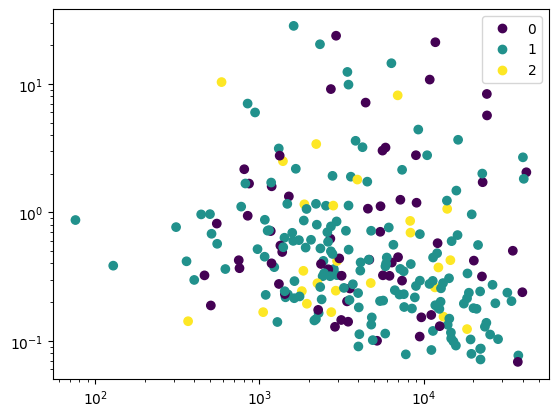

In [53]:
color = clin_values['sbjGroup'].values
scatter = plt.scatter(wmh_mass, slice_dmg_ratio_variances, c=color, label=color)
plt.xscale('log')
plt.yscale('log')
plt.legend(*scatter.legend_elements())

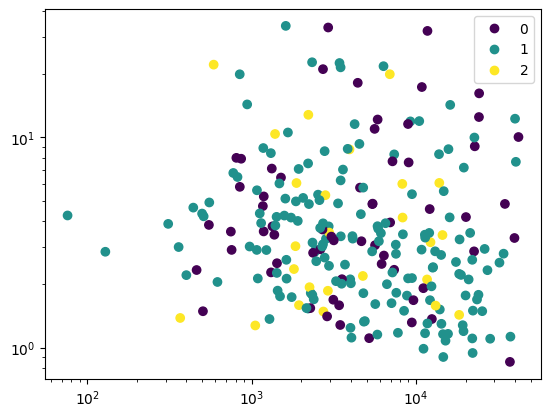

In [54]:
color = clin_values['sbjGroup'].values
scatter = plt.scatter(wmh_mass, max_slice_dmgs, c=color, label=color)
plt.xscale('log')
plt.yscale('log')
plt.legend(*scatter.legend_elements())

### looking at the difference between the confidence and the ent map
We can see clearly here that there is a possiblity for the ent_map to be highlighting extra information even when the damage score
is just using confidence...

Text(0.5, 1.0, 'dmg map')

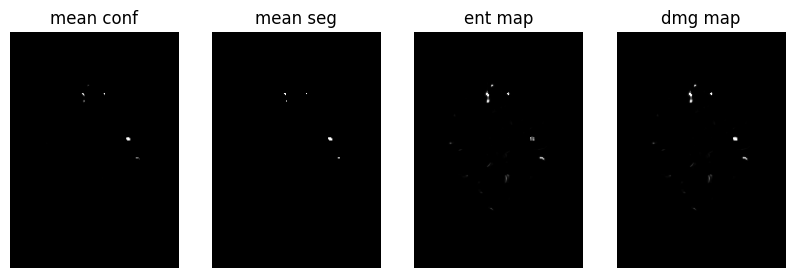

In [55]:
pos = 8
slice_id = 30
plt.figure(figsize=(10, 5))
plt.subplot(1,4,1)
plt.imshow(torch.nn.functional.softmax(means[pos], dim=1)[slice_id, 1], cmap='gray'); plt.axis('off'); plt.title("mean conf")
plt.subplot(1,4,2)
plt.imshow(torch.nn.functional.softmax(means[pos], dim=1)[slice_id, 1] > 0.5, cmap='gray'); plt.axis('off'); plt.title("mean seg")
plt.subplot(1,4,3)
plt.imshow(ent_maps[pos][slice_id], cmap='gray'); plt.axis('off'); plt.title("ent map")
plt.subplot(1,4,4)
plt.imshow(dmg_maps[pos][slice_id], cmap='gray'); plt.axis('off'); plt.title("dmg map")

### Looking at the output of fast results (used for computing damage score)

In [56]:
import torchvision as tv
from twaidata.MRI_preprep.resample import resample_and_return, get_resampled_img
from natsort import natsorted
import nibabel as nib
from collections import defaultdict

In [57]:
fast_folder = "/home/s2208943/ipdis/data/preprocessed_data/Ed_fast_WM_masks/"

In [58]:
# output of fast results:
# we have to resample the image first
fnames = [name for name in natsorted(os.listdir(fast_folder)) if (".nii.gz" in name and "_T1_BET_" in name and ("pveseg" in name or "pve_2" in name))]
fnames = natsorted(fnames)

# the old way that I was loading the images, its bad because the resampling isn't done so the masks don't line up!
# imgs = []
# # this takes a couple of minutes as it is loading from the dfs
# for name in tqdm(fnames, position=0, leave=True):
#      imgs.append(np.array(nib.load(fast_folder+name).dataobj))

In [59]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.]):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [60]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((224, 160))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [61]:
# individual example
pos = 8
ID = clin_values.iloc[pos]['ID']
num_slices = dataset[pos][0].shape[1]

sel_files = [f for f in natsorted(os.listdir(fast_folder)) if ID in f and "_T1_BET_" in f]

In [62]:
sel_files

['CVD052_T1_BET_mixeltype.nii.gz',
 'CVD052_T1_BET_pve_0.nii.gz',
 'CVD052_T1_BET_pve_1.nii.gz',
 'CVD052_T1_BET_pve_2.nii.gz',
 'CVD052_T1_BET_pveseg.nii.gz',
 'CVD052_T1_BET_seg.nii.gz']

In [63]:
individual_fast_examples = [load_fast_output(fast_folder + f, num_slices) for f in sel_files]

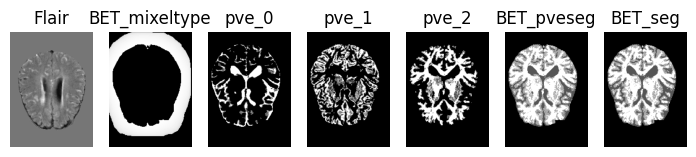

In [64]:
slice_id = 25
scan_id = pos
i = 1
rows = 1
cols = 8
plt.figure(figsize=(10, 3))
i = plot_subimg(dataset[scan_id][0][0][slice_id], rows=rows, cols=cols, i=i, title='Flair')
for j, img in enumerate(individual_fast_examples):
    i = plot_subimg(img[slice_id], rows=rows, cols=cols, i=i, title="_".join(sel_files[j].split(".")[0].split("_")[-2:]))

Ask maria about this?


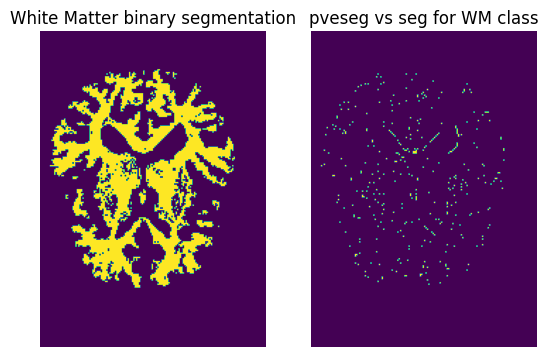

In [65]:
print("Ask maria about this?")
plt.subplot(1,2,1)
plt.imshow(individual_fast_examples[-2][slice_id] == 3); plt.axis('off'); plt.title("White Matter binary segmentation")
plt.subplot(1,2,2)
plt.imshow((individual_fast_examples[-2][slice_id] == 3) != (individual_fast_examples[-1][slice_id] == 3)); plt.axis('off'); plt.title("pveseg vs seg for WM class");

***NOTE:*** so, I can use the binary segmentation, use pveseg == 2, or I can use the WM probability map. Lets look at what the flair * these values would look like
(and then what the flair * confidence map, * the ent map, * the damage map and * the hard mean segmentation would look like.
One thing I can also try is setting a baseline threshold for the uncertianty (cutting off anything outside that uncertainty), otherwise there will be a lot of voxels at low volume adding in to the uncertianty, (I should also set it to zero outside the mask I guess.)

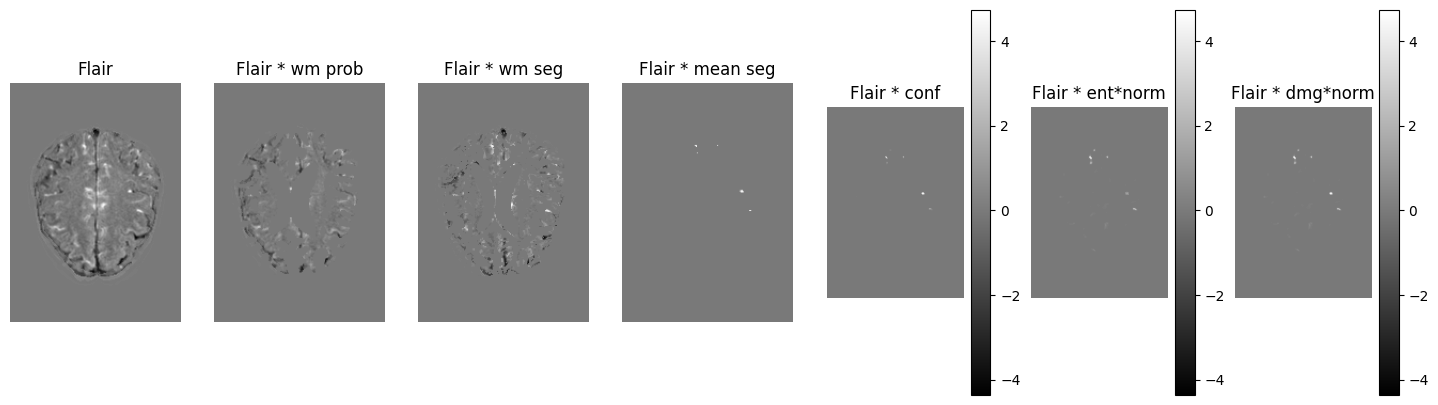

In [66]:
rows = 1
cols = 7
i = 1
scan_id = 8
slice_id = 30


plt.figure(figsize=(18, 5))
# flair
flair = dataset[scan_id][0][0][slice_id]
vmin = flair.min()
vmax = flair.max()
i = plot_subimg(flair, rows=rows, cols=cols, i=i, title='Flair', vmin=vmin, vmax=vmax)

# flair * fast wm probability distribution
i = plot_subimg(flair * individual_fast_examples[3][slice_id], rows=rows, cols=cols, i=i, title='Flair * wm prob', vmin=vmin, vmax=vmax)

# flair * fast wm hard seg
i = plot_subimg(flair * (individual_fast_examples[-1][slice_id]==2), rows=rows, cols=cols, i=i, title='Flair * wm seg', vmin=vmin, vmax=vmax)

# flair * wm mean seg conf (note that the output between the two classes is not entirely the same)
i = plot_subimg(flair * means[scan_id].argmax(dim=1)[slice_id], rows=rows, cols=cols, i=i, title='Flair * mean seg', vmin=vmin, vmax=vmax)

# flair * the mean conf
i = plot_subimg(flair * torch.nn.functional.softmax(means[scan_id], dim=1)[slice_id, 1], rows=rows, cols=cols, i=i, title='Flair * conf', vmin=vmin, vmax=vmax)
plt.colorbar()

# flair * the ent map
ent_norm_factor = 1/max_ent
i = plot_subimg(flair * (ent_maps[scan_id][slice_id]*ent_norm_factor), rows=rows, cols=cols, i=i, title='Flair * ent*norm', vmin=vmin, vmax=vmax)
plt.colorbar()

# flair * dmg map
i = plot_subimg(flair * (dmg_maps[scan_id][slice_id]*ent_norm_factor), rows=rows, cols=cols, i=i, title='Flair * dmg*norm', vmin=vmin, vmax=vmax)
plt.colorbar()

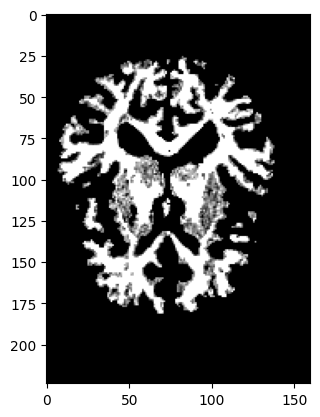

In [67]:
plt.imshow(individual_fast_examples[3][25], cmap='gray');
# example of the white matter segmentation

In [68]:
individual_fast_examples[4].min()

tensor(0.)

### Converting the uncertainty maps back to the original shape for maria

In [69]:
import SimpleITK as sitk
from twaidata.MRI_preprep.resample import resample_and_return, get_resampled_img

In [70]:
# individual example
pos = 8
ID = clin_values.iloc[pos]['ID']
num_slices = dataset[pos][0].shape[1]

sel_files = [f for f in natsorted(os.listdir(fast_folder)) if ID in f and "_T1_BET_" in f]

In [71]:
example_wm = fast_folder + sel_files[3]
orig_img = sitk.ReadImage(example_wm)
orig_spacing = orig_img.GetSpacing()
orig_shape = sitk.GetArrayFromImage(orig_img).shape
orig_channels = orig_shape[0]
sel_files[3]

prepped_img = ent_maps[pos]
prepped_channels = prepped_img.shape[0]

In [72]:
orig_spacing

(0.9375, 0.9375, 3.9999868869781494)

In [73]:
# plt.subplot(1,2,1)
# plt.imshow(sitk.GetArrayFromImage(orig_img)[channels//2], cmap='magma'); plt.axis('off')
# plt.subplot(1,2,2)

# plt.imshow(prepped_img[prepped_channels//2], cmap='magma'); plt.axis('off')
# plt.suptitle("before reshaping img back to input scale");

In [74]:
def reverse_resampling_of_image(wm_file, img_to_resample, save_location=None, name=None):
    # load the wm file that is in the target shape  and sampling
    orig_img = sitk.ReadImage(wm_file)
    orig_spacing = orig_img.GetSpacing()
    orig_shape = sitk.GetArrayFromImage(orig_img).shape
    
    # get the un padded shape of the resampled version of the original image shape
    timg = resample_and_return(wm_file, is_label=True)
    timg = torch.Tensor(timg)
    h_orig, w_orig = timg.shape[1:]
    
    # perform padding
    h, w = img_to_resample.shape[1:]
    h_diff = (h_orig - h) // 2
    w_diff = (w_orig - w) // 2
    new_img = torch.nn.functional.pad(img_to_resample, pad=(w_diff, w_diff, h_diff, h_diff), mode='constant', value=0)
    
    # resample
    new_img = sitk.GetImageFromArray(new_img)
    new_img.SetSpacing([1., 1., 3.]) # the spacing that was used as the out spacing during the preprocessing stage
    # we need to tell the sitk image what the true spacing prior to resampling is because it doesn't know as its just taken from a numpy array
    new_img = get_resampled_img(new_img, is_label=True, out_spacing=orig_spacing)
    
    if save_location:
        sitk.WriteImage(new_img, f"{save_location}{name}.nii.gz")
    else:
        return new_img

In [75]:
#new_img = reverse_resampling_of_image(fast_folder + sel_files[3], ent_maps[pos])

In [76]:
# plt.subplot(1,2,1)
# plt.imshow(sitk.GetArrayFromImage(orig_img)[channels//2], cmap='magma'); plt.axis('off')
# plt.subplot(1,2,2)

# plt.imshow(sitk.GetArrayFromImage(new_img)[channels//2], cmap='magma'); plt.axis('off')
# plt.suptitle("AFTER reshaping img back to input scale");

In [77]:
max_ent = -math.log(0.5)
max_ent

0.6931471805599453

In [78]:
1/max_ent

1.4426950408889634

In [79]:
torch.nn.functional.softmax(means[0], dim=1)[:,1].shape

torch.Size([40, 224, 160])

In [80]:
# for pos in tqdm(range(len(dataset)), position=0, leave=True):
#     ID = clin_values.iloc[pos]['ID']
#     wm_path = fast_folder + ID + "_T1_BET_pve_2.nii.gz"
#     result_dir = "/home/s2208943/ipdis/data/preprocessed_data/EdData_umaps/"
    
#     ent = ent_maps[pos] / max_ent
#     comb = dmg_maps[pos] / max_ent
#     seg = torch.nn.functional.softmax(means[pos], dim=1)[:,1]
    
#     reverse_resampling_of_image(wm_path, ent, result_dir, ID + "_ent_map")
#     reverse_resampling_of_image(wm_path, comb, result_dir, ID + "_comb_map")
#     reverse_resampling_of_image(wm_path, seg, result_dir, ID + "_seg_map")
    
    

### Loading the fast images for each scan
need to load the pve_2 and the pve_seg files (but need to ask maria the difference between pve_seg and seg)

In [81]:
fast_imgs = defaultdict(lambda: {})

for pos in tqdm(range(len(dataset)), position=0, leave=True):
    # get target image named
    ID = clin_values.iloc[pos]['ID']
    locs = [i for i in range(len(fnames)) if ID in fnames[i]]
    selected_fnames = [fnames[i] for i in locs]
    
    target_shape = dataset[pos][0][0].shape
    num_slices = target_shape[0]
    
    for name in selected_fnames:
        # resample the image (should have done this during the preprocess)
        timg = load_fast_output(fast_folder + name, num_slices)
        
        fast_imgs[ID][name] = timg

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:55<00:00,  4.47it/s]


In [82]:
pos = 8
ID = clin_values.iloc[pos]['ID']
flair = dataset[pos][0][0]

imgs = list(fast_imgs[ID].values())
keys = list(fast_imgs[ID].keys())

In [83]:
keys

['CVD052_T1_BET_pve_2.nii.gz', 'CVD052_T1_BET_pveseg.nii.gz']

### Computing the damage scores in various guises, normalized and un-normalized

when computing the damage score, I could threshold the uncertainty, or I could try multiplying the intensities by the uncertainty threshold, those that are outside the mean segmentaion..?
Or, I could take any pixel with uncertainty > 0.01 and multiply it by the uncertainty when contributing it to the damage score in some way...? Interesting... I need to ensure the uncertainty damage score is always greater than the WMH damage score?
or I could try one where the uncertainty damage score can be theoretically less?

In [84]:
max_ent

0.6931471805599453

In [85]:
# new damage score functions
def normalize01_scale(img):
    return (img - img.min()) / (img.max() - img.min())

def damage_score_thresholded(flair, wmh_mask, wm_mask, brain_mask, normalize_flair=True):
    if normalize_flair:
        flair = normalize01_scale(flair)
        
    wm_voxels = flair[(wm_mask == 1) & (wmh_mask != 1) & (brain_mask==1)]
    wmh_voxels = flair[(wmh_mask == 1) & (brain_mask==1)]
    
    I_wm = wm_voxels.mean().item()
    I_wmh = wmh_voxels.mean().item()
    
    vol_wm = wm_voxels.shape[0]
    vol_wmh = wmh_voxels.shape[0]
    
    try:
        damage = ((I_wmh - I_wm) / I_wm) * (vol_wmh / (vol_wmh + vol_wm))
    
        return damage
    except:
        return torch.nan
        

def damage_score_probabilistic(flair, wmh_map, wm_map, brain_mask, normalize_flair=True, min_threshold=0.01, bias=1):
    if normalize_flair:
        flair = normalize01_scale(flair)
        
    wm_prob_weighted = (wm_map * flair)[(wm_map > min_threshold) & (wmh_map < min_threshold) & (brain_mask==1)]
    wmh_prob_weighted = (wmh_map * flair)[(wmh_map > min_threshold) & (brain_mask==1)]
    
    I_wm = wm_prob_weighted.mean()
    I_wmh = wmh_prob_weighted.mean()
    
    vol_wm = wm_map.sum()
    vol_wmh = wmh_map.sum()
    
    try:
        damage = ((I_wmh - I_wm) / I_wm) * (vol_wmh / (vol_wmh + vol_wm)) + bias
    
        return damage.item()
    except:
        return torch.nan
    
    return damage

In [86]:
torch.nan

nan

In [87]:
# the damage scores that we can compute:
# threshold the uncertainty at different levels, 0.01, 0.1, 0.2, 0.3, 0.4
# or a different damage metric where we increase the volume of the WMH using the uncertainty map
# we don't change the IWMH (as it highlights a greater background area which has lower uncertainty
# but it also highlights it with different levels of uncertainty which we want to be sensitive too

# okay, to build all my damage scores, I have the following to do:
# build the filters for each image
# do the 5 types of damage score.
# compute this for each image. Then we are ready to get modelling.

uncert_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
min_prob_thresh = 0.3
bias=1

def generate_damage_scores(uncert_thresholds, normalize):
    rows = []

    for pos in tqdm(range(len(dataset)), position=0, leave=True):
        row = {}
        
        # get target image named
        ID = clin_values.iloc[pos]['ID']
        row['ID'] = ID

        flair = dataset[pos][0][0].cuda()
        mask = dataset[pos][0][1].cuda()
        wmh = means[pos].cuda()
        
        # zero the dmg and ent maps outside the mask (I forgot to do it earlier oops)
        # and normalize them to 0-1 entropy range
        ent_normalizer = 1/max_ent
        dmg_map = dmg_maps[pos].cuda() * mask * ent_normalizer
        ent_map = ent_maps[pos].cuda() * mask * ent_normalizer

        # build the 'nawm' (as maria is defining it?) mask options
        fast_map = fast_imgs[ID]
        wm_map = fast_map[ID + "_T1_BET_pve_2.nii.gz"].cuda()
        wm_seg = fast_map[ID + "_T1_BET_pveseg.nii.gz"].cuda() == 3 # 0 = fast brain mask (is it different to bet?), 1 = csf, 2 = gray, 3 = white

        # compute the soft damage scores for mean conf, umap, dmg_map,
        row["mean_dmg"] = damage_score_probabilistic(flair, torch.nn.functional.softmax(wmh, dim=1)[:,1], wm_map, mask, normalize_flair=normalize, min_threshold=min_prob_thresh, bias=bias)
        row["ent_dmg"] = damage_score_probabilistic(flair, ent_map, wm_map, mask, normalize_flair=normalize, min_threshold=min_prob_thresh, bias=bias)
        row["comb_dmg"] = damage_score_probabilistic(flair, dmg_map, wm_map, mask, normalize_flair=normalize, min_threshold=min_prob_thresh, bias=bias)
        
        # hard damage score for mean
        row["mean_thresh_dmg"] = damage_score_thresholded(flair, wmh.argmax(dim=1), wm_seg, mask, normalize_flair=normalize)
        
        # hard damage score for uncertainty maps at varying thresholds
        for t in uncert_thresholds:
            row[f"ent>{t}_thresh_dmg"] = damage_score_thresholded(flair, ent_map > (t*ent_normalizer), wm_seg, mask, normalize_flair=normalize)
            row[f"comb>{t}_thresh_dmg"] = damage_score_thresholded(flair, dmg_map > (t*ent_normalizer), wm_seg, mask, normalize_flair=normalize)
        
        rows.append(row)
    
    return rows

In [88]:
dmg_rows = generate_damage_scores(uncert_thresholds, normalize=False)
dmg_df = pd.DataFrame(dmg_rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 38.38it/s]


In [89]:
dmg_norm_rows = generate_damage_scores(uncert_thresholds, normalize=True)
dmg_norm_df = pd.DataFrame(dmg_norm_rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 39.97it/s]


In [90]:
dmg_norm_df

,ID,mean_dmg,ent_dmg,comb_dmg,mean_thresh_dmg,ent>0.1_thresh_dmg,comb>0.1_thresh_dmg,ent>0.2_thresh_dmg,comb>0.2_thresh_dmg,ent>0.3_thresh_dmg,comb>0.3_thresh_dmg,ent>0.4_thresh_dmg,comb>0.4_thresh_dmg,ent>0.5_thresh_dmg,comb>0.5_thresh_dmg
0,CVD008,1.033850,0.998817,1.047390,0.037369,0.049817,0.060971,0.034887,0.054846,0.025952,0.050877,0.019619,0.047757,0.014247,0.044988
1,CVD014,1.007174,0.999416,1.010798,0.008373,0.026040,0.026717,0.018086,0.020491,0.012502,0.016507,0.009013,0.014000,0.006382,0.012158
2,CVD016,1.083611,1.005195,1.102173,0.090228,0.091137,0.130974,0.055426,0.119989,0.039734,0.113075,0.030230,0.107840,0.022367,0.103246
3,CVD018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CVD023,1.028015,1.003131,1.038568,0.029401,0.046243,0.054611,0.026432,0.044704,0.018777,0.040368,0.013541,0.037280,0.009904,0.035022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,CVD321,1.019496,1.001706,1.027083,0.027262,0.052011,0.061764,0.034124,0.048966,0.024596,0.042491,0.018356,0.038293,0.013237,0.034953
246,CVD322,1.000512,0.998200,0.999469,0.000854,0.006149,0.006149,0.003020,0.003068,0.001741,0.001901,0.001093,0.001444,0.000738,0.001233
247,CVD323,1.005860,0.996602,1.006621,0.010529,0.028138,0.030893,0.019110,0.023735,0.013727,0.019669,0.010089,0.016858,0.007411,0.014950
248,CVD324,1.017211,0.995685,1.021418,0.023497,0.042925,0.050226,0.027347,0.040297,0.019811,0.035473,0.014602,0.032083,0.010360,0.029365


In [91]:
dmg_norm_df['comb_dmg'].max()

1.1766293048858643

In [92]:
dmg_norm_df

,ID,mean_dmg,ent_dmg,comb_dmg,mean_thresh_dmg,ent>0.1_thresh_dmg,comb>0.1_thresh_dmg,ent>0.2_thresh_dmg,comb>0.2_thresh_dmg,ent>0.3_thresh_dmg,comb>0.3_thresh_dmg,ent>0.4_thresh_dmg,comb>0.4_thresh_dmg,ent>0.5_thresh_dmg,comb>0.5_thresh_dmg
0,CVD008,1.033850,0.998817,1.047390,0.037369,0.049817,0.060971,0.034887,0.054846,0.025952,0.050877,0.019619,0.047757,0.014247,0.044988
1,CVD014,1.007174,0.999416,1.010798,0.008373,0.026040,0.026717,0.018086,0.020491,0.012502,0.016507,0.009013,0.014000,0.006382,0.012158
2,CVD016,1.083611,1.005195,1.102173,0.090228,0.091137,0.130974,0.055426,0.119989,0.039734,0.113075,0.030230,0.107840,0.022367,0.103246
3,CVD018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CVD023,1.028015,1.003131,1.038568,0.029401,0.046243,0.054611,0.026432,0.044704,0.018777,0.040368,0.013541,0.037280,0.009904,0.035022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,CVD321,1.019496,1.001706,1.027083,0.027262,0.052011,0.061764,0.034124,0.048966,0.024596,0.042491,0.018356,0.038293,0.013237,0.034953
246,CVD322,1.000512,0.998200,0.999469,0.000854,0.006149,0.006149,0.003020,0.003068,0.001741,0.001901,0.001093,0.001444,0.000738,0.001233
247,CVD323,1.005860,0.996602,1.006621,0.010529,0.028138,0.030893,0.019110,0.023735,0.013727,0.019669,0.010089,0.016858,0.007411,0.014950
248,CVD324,1.017211,0.995685,1.021418,0.023497,0.042925,0.050226,0.027347,0.040297,0.019811,0.035473,0.014602,0.032083,0.010360,0.029365


In [93]:
dmg_norm_df['ent_dmg'].values

array([0.99881679, 0.99941641, 1.00519502,        nan, 1.00313067,
       0.99898851, 0.99862784, 1.00913179, 0.999865  , 0.99964637,
       1.01951611, 0.99951625, 1.01495314, 0.99848294, 0.9985289 ,
       0.99756557, 0.99841028, 0.99861085, 1.00036681, 0.99901408,
       1.00061071, 0.99934357, 1.01015091, 0.99794823, 1.00020325,
       1.00733817, 1.01756692, 1.00058866, 1.00404441, 0.99904031,
       1.00000894, 0.99914068, 1.00614703, 1.00301003, 1.00145042,
       1.01121473, 0.99826634, 1.00031388, 1.00140512, 1.00321686,
       1.00023949, 0.99776089, 1.00977826, 1.00150955, 0.99817318,
       1.00812852, 0.99920648, 1.00486124, 0.99928093, 0.99831873,
       0.99949276, 0.9993723 , 0.99932247, 0.99981707, 0.99817818,
       0.99836707, 0.99936682, 0.99972111, 0.99965268, 0.99977911,
       0.99838555, 0.99966007, 0.99963212, 0.99837679, 0.99923933,
       0.99936849, 0.99952173, 0.9984411 , 0.99952239, 0.99875456,
       0.99877208, 0.99956447, 0.99884981, 0.99806261, 0.99947

### Building the clinscores table for linear model training

from the plots it is hard to see a clear link with stroke and excess uncertainty.
First I should look at the validation and test data combined to see how they fare.
Then fit a line to some of these plots, and record the distance away from the curve
Then, start adding the values I have computed to the clin-scores table so that we can try and fit some models with it. Look up that beta value thing.
See if we can find a linear model that takes a combination of factors and can predict these things.

**NOTE**: for doing any future analysis properly, I need to cross validate my training data, so that I have valid data to experiment with and for fitting models (so that i have each element in the test data and
I can look at the prediction scores across all the images. Important to do....

In [94]:
# adding derived fields
other_scores_df = {}
other_scores_df['ID'] = clin_values['ID'].values
other_scores_df["wmh_gt_vol"] = wmh_mass
other_scores_df["mean_vol"] = mean_mass
other_scores_df["uncert_vol"] = uncert_mass
other_scores_df["comb_vol"] = dmg_mass
other_scores_df["(comb-mean_scaled)/surface_area"] = (dmg_mass - mean_dmg_mass)/surface_area
other_scores_df["(dmg-mean_scaled)"] = dmg_mass - mean_dmg_mass
other_scores_df["max slice (comb-mean_s)/sa"] = max_slice_dmgs
other_scores_df = pd.DataFrame(other_scores_df)

In [95]:
other_scores_df

,ID,wmh_gt_vol,mean_vol,uncert_vol,comb_vol,(comb-mean_scaled)/surface_area,(dmg-mean_scaled),max slice (comb-mean_s)/sa
0,CVD008,19447.0,18548.0,17454.857422,24179.656250,0.477609,11323.162109,1.198124
1,CVD014,6653.0,4488.0,8184.041992,9476.925781,0.808289,6366.081055,2.003300
2,CVD016,25277.0,25944.0,21090.501953,32221.916016,0.584400,14238.906250,1.491428
3,CVD018,9240.0,8521.0,27407.970703,28736.224609,2.285735,22829.917969,11.892115
4,CVD023,7368.0,7693.0,8707.060547,11765.529297,0.593190,6433.147949,8.289367
...,...,...,...,...,...,...,...,...
245,CVD321,10463.0,8036.0,11402.253906,14340.078125,0.826029,8769.947266,11.930600
246,CVD322,76.0,333.0,1502.716064,1572.281982,1.156434,1341.463989,4.249221
247,CVD323,6115.0,4077.0,8615.172852,9902.191406,0.823680,7076.230469,3.499999
248,CVD324,11319.0,9922.0,13536.814453,17243.130859,0.645236,10365.724609,3.442181


In [96]:
all_dmg_scores = pd.concat([other_scores_df, dmg_norm_df], join='outer', axis=1)

In [97]:
#all_dmg_scores.to_excel("CVD_dmg_scores.xlsx")

In [49]:
"""AUX FUNCTIONS"""

def convert_symbol_to_nan(df, field, symbol):
    df = df.copy()
    """
    converts all inputs conforming to 'symbol' to np.nan for the given 'field' in the 'df'
    e.g if symbol=' ' and field='totalChl' then any instances of ' ' in the 'totalChl' column will be replaced with np.nan
    """
    values = df[field].values
    locs = values == symbol
    values[locs] = np.nan
    
    df[field] = values
    
    return df

def filter_rows_with_nans(df, field, inplace=False):
    """
    removes all rows from df which have nan for the given field value
    """
    values = df[field].values
    nan_locs = np.where(np.isnan(values))[0]
    df = df.drop(nan_locs, inplace=inplace)
    df = df.reset_index(drop=True)
    
    return df
    
    
def one_hot_encode(df, field, remove_original=True):
    """computes a one hot encoding of the given field"""
    
    onehot_cols = pd.get_dummies(df[field], prefix=field)
    
    if remove_original:
        df = df.drop(columns=[field], inplace=False)
        
    df = pd.concat([df, onehot_cols], axis=1)
    
    return df
    
    

In [50]:
def preprep_clinscores(
    df,
    fields,
    inc_brain_scores=False,
    nan_filter_dict = {'hyperlipidaemia': 'row', 'smoking':'row', 'SBP':'row', 'DBP':'row', 'MMSE':'col', 'relLes':'row'},
    other_fields_policy = 'row',
    relLes_default = 0,
    one_hot_fields = None,
    remove_one_hot_originals = True,
    log_fields = None,
    normalize_fields = None,
    convert_strokeLes = False,
    ):
    
    """
    fields: a list of fields to keep in preprocessed table.
    
    inc_brain_scores: <True, False> includes the following fields, which are otherwise missing collectively in multiple rows: PVWMH, DWMH, deepAtrophy, supAtrophy, BGPVS, CSPVS, oldLes, relLes
        if true rows missing these values are skipped
        if false, the column entirely is skipped.
    
    nan_filter_dict: {key: <'row', 'col', None>} a dictionary of field names and filter options. 
                if filter = row, rows with this field equal to Nan are ignored. if filter = col, the column is removed if there are any Nans in the column. if filter = None: do nothing.
                the same behaviour as inc_brain_scores but for specified fields.
    
    relLes_default: value to set relLes to when sbjGroup = 0 (community dwelling). relLes cannot be 1 in this case and is stored as Nan but this is unhelpful. default 0.
    
    one_hot_fields: list of field names to be converted to one hot encoding. None if no fields to be converted.
    
    remove_one_hot_originals: remove the original column that the one-hot fields were generated from.
    
    log_fields: fields converted to log form
    
    """
    df = df.copy() # ensure we don't onverwrite stuff in source df.
    
    # deal with bad field in totalChl field
    df = convert_symbol_to_nan(df, 'totalChl', ' ')
    df['totalChl'] = df['totalChl'].values.astype(np.float32)
    
    # set relLes to default value where sbjGroup = 0 and relLes is Nan
    relLes = df['relLes'].values
    relLes[(df['sbjGroup'].values == 0) & np.isnan(relLes)] = relLes_default
    df['relLes'] = relLes
    
    # select the chosen fields
    df = df[fields]
    
    # ignore the brain score fields
    if not inc_brain_scores:
        df = df.drop(columns=['PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'oldLes', 'relLes'], inplace=False)
    
    # filter fields
    keys = df.keys()
    for field, behaviour in nan_filter_dict.items():
        if field not in keys:
            continue
        if behaviour == None:
            continue
        elif behaviour == 'row':
            df = filter_rows_with_nans(df, field)
        elif behaviour == 'col':
            if np.sum(np.isnan(df[field].values)) > 0:
                df = df.drop(columns=[field], inplace=False)
        else:
            raise ValueError(f"nan_filter_dict must contain key:<'row', col', None> pairs, not {behaviour}")
    
    # one hot encoding (ignore the field if it is not present)
    keys = df.keys()
    if one_hot_fields:
        for field in one_hot_fields:
            if field in keys:
                df = one_hot_encode(df, field, remove_one_hot_originals)
                
    if other_fields_policy:
        for field in df.keys():
            if other_fields_policy == 'row':
                try:
                    df = filter_rows_with_nans(df, field)
                except:
                    print("skipping filtering col: ", field)
            elif other_fields_policy == 'col':
                if np.sum(np.isnan(df[field].values)) > 0:
                    df = df.drop(columns=[field], inplace=False)
            else:
                raise ValueError(f"other_fields_policy must be:<'row', col', None> pairs, not {other_fields_policy}")
                
    # log specific fields
    if log_fields:
        for field in log_fields:
            df[field] = np.log(df[field].values + 1e-30)
            
    if normalize_fields:
        for field in normalize_fields:
            values = df[field].values
            values = (values - np.mean(values)) / np.std(values)
            df[field] = values
            
        
    if convert_strokeLes: 
        #convert relLes and oldLes to a single field
        print(df['relLes'].values)
        df['les'] = (df['relLes'].values * df['oldLes'].values)
        df = df.drop(columns=['oldLes', 'relLes'], inplace=False)
            
    return df

In [100]:
print("THIS IS A CONCERNING POINT TO TALK TO MARIA ABOUT")
(clin_values.loc[clin_values['sbjGroup'] == 2])[['PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'oldLes', 'relLes']]

THIS IS A CONCERNING POINT TO TALK TO MARIA ABOUT


,PVWMH,DWMH,deepAtrophy,supAtrophy,BGPVS,CSPVS,oldLes,relLes
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Time to start doing some linear modelling....

In [101]:
# using the non-normalized version of the damage score (which can include negative areas in the mass sum causing issues....
combined_df = pd.concat([clin_values, dmg_norm_df, other_scores_df], join='outer', axis=1)

In [102]:
combined_df.keys()

Index(['Unnamed: 0', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld', 'ID', 'mean_dmg',
       'ent_dmg', 'comb_dmg', 'mean_thresh_dmg', 'ent>0.1_thresh_dmg',
       'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg', 'comb>0.2_thresh_dmg',
       'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg', 'ent>0.4_thresh_dmg',
       'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg', 'comb>0.5_thresh_dmg',
       'ID', 'wmh_gt_vol', 'mean_vol', 'uncert_vol', 'comb_vol',
       '(comb-mean_scaled)/surface_area', '(dmg-mean_scaled)',
       'max slice (comb-mean_s)/sa'],
      dtype='object')

In [155]:
# pick our dataset
wm_filter = 'wm1' # 'wm1', 'wm1+2'

df = preprep_clinscores(
    df=combined_df,
    fields=['ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld', 'mean_dmg', 'ent_dmg', 'comb_dmg', 'mean_thresh_dmg',
       'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
       'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
       'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
       'comb>0.5_thresh_dmg', 'wmh_gt_vol', 'mean_vol',
       'uncert_vol', 'comb_vol', '(comb-mean_scaled)/surface_area', 'max slice (comb-mean_s)/sa'],
    inc_brain_scores=True,
    nan_filter_dict = {'hyperlipidaemia': 'row', 'smoking':'row', 'SBP':'col', 'DBP':'col', 'MMSE':'col', 'relLes':'row', 'ICV':'row', 'totalChl': 'col', 'micrBld': 'row'},
    other_fields_policy = 'row',#'col',
    relLes_default = 0,
    one_hot_fields = ['sbjGroup', 'smoking', 'PVWMH', 'DWMH'],
    remove_one_hot_originals = False,
    log_fields = ['mean_dmg', 'ent_dmg', 'comb_dmg', 'mean_thresh_dmg',
       'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
       'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
       'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
       'comb>0.5_thresh_dmg', 'wmh_gt_vol', 'mean_vol',
       'uncert_vol', 'comb_vol', '(comb-mean_scaled)/surface_area', 'max slice (comb-mean_s)/sa'],
    normalize_fields = ['age', 'ICV'],
    convert_strokeLes=True
)

skipping filtering col:  ID
skipping filtering col:  ID
skipping filtering col:  ID
[1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1.]


In [156]:
df.keys()

Index(['ID', 'ID', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes', 'hypertension',
       'hyperlipidaemia', 'smoking', 'ICV', 'WMH', 'PVWMH', 'DWMH',
       'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'micrBld', 'mean_dmg',
       'ent_dmg', 'comb_dmg', 'mean_thresh_dmg', 'ent>0.1_thresh_dmg',
       'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg', 'comb>0.2_thresh_dmg',
       'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg', 'ent>0.4_thresh_dmg',
       'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg', 'comb>0.5_thresh_dmg',
       'wmh_gt_vol', 'mean_vol', 'uncert_vol', 'comb_vol',
       '(comb-mean_scaled)/surface_area', 'max slice (comb-mean_s)/sa',
       'sbjGroup_0', 'sbjGroup_1', 'smoking_0.0', 'smoking_1.0', 'smoking_2.0',
       'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
       'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0', 'les'],
      dtype='object')

things I can try:
- not normalizing age
- not taking the log of my target fields
- try the following targets:
    - normalized damage scores
    - other filter types
    - thresholded uncertainty vs specific uncertainty
    - predicting the umap volume directly
    - predicted the scaled umap thing
    - predicting the 'worst slice' damage score
- try different versions of the uncertainty maps (variance, kernel density estimates)
- try predicting something from the uncertainty map, e.g the fazekas score, or relLes, from the uncertianty map metrics, can include all the uncertainty map metrics
- also try given the uncertainty map vs given the mean segmentation what can we predict. (does uncertainty map improve things?) Lets see.
- yeah I like the lets try predicting each different biomarker idea (given all the other biomarkers) so lets do that.
- I notice it can predict the uncertainty map damage given the true damage hmmm these values are just too close...

In [157]:
#df[f'{wm_filter}/dmg>0.4_damage'].values

In [158]:
from sklearn import linear_model
from sklearn import tree
from sklearn import svm

In [159]:
from sklearn.model_selection import train_test_split

In [160]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1234)

In [171]:
reg = linear_model.LinearRegression()
# reg = linear_model.ARDRegression()
# reg = linear_model.Lasso(alpha=0.1)
# reg = linear_model.BayesianRidge()
# reg = tree.DecisionTreeRegressor()
# reg = svm.SVR()
# reg = linear_model.HuberRegressor(max_iter=5000)
# reg = linear_model.TheilSenRegressor(max_iter=500)

In [172]:
predict_keys = ['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia', 'ICV',
       'BGPVS', 'CSPVS', 'les', 'micrBld', 'sbjGroup_0', 'sbjGroup_1', 'PVWMH_0.0',
                'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0', 'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0',
                'smoking_0.0', 'smoking_1.0', 'smoking_2.0', 'deepAtrophy', 'supAtrophy' ]

In [173]:
train_df.keys()

Index(['ID', 'ID', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes', 'hypertension',
       'hyperlipidaemia', 'smoking', 'ICV', 'WMH', 'PVWMH', 'DWMH',
       'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'micrBld', 'mean_dmg',
       'ent_dmg', 'comb_dmg', 'mean_thresh_dmg', 'ent>0.1_thresh_dmg',
       'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg', 'comb>0.2_thresh_dmg',
       'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg', 'ent>0.4_thresh_dmg',
       'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg', 'comb>0.5_thresh_dmg',
       'wmh_gt_vol', 'mean_vol', 'uncert_vol', 'comb_vol',
       '(comb-mean_scaled)/surface_area', 'max slice (comb-mean_s)/sa',
       'sbjGroup_0', 'sbjGroup_1', 'smoking_0.0', 'smoking_1.0', 'smoking_2.0',
       'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
       'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0', 'les'],
      dtype='object')

In [174]:
def train_model(columns, return_diff=False):
    X_train = train_df.drop(columns=columns)
    X_test = test_df.drop(columns=columns)

    y_train = train_df[label]
    y_test = test_df[label]
    
    reg.fit(X_train, y_train)
    
    X, y = X_test, y_test
    
    if return_diff:
        return np.abs((reg.predict(X) - y).values), X, y
    return (((reg.predict(X) - y).values)**2).mean()


rows = []
for key in predict_keys:
    clin_columns = ['sbjGroup', 'age', 'sex', 'diabetes', 'hypertension',
           'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl', 'ICV', 'WMH',
           'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS',
           'les', 'micrBld','sbjGroup_0', 'sbjGroup_1', 'smoking_0.0', 'smoking_1.0', 'smoking_2.0',
           'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
           'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0']

    one_hot_drop = ['sbjGroup', 'smoking', 'PVWMH', 'DWMH']

    wmh_fields = ['mean_vol', 'mean_dmg', 'mean_thresh_dmg']
    wmh_drops = []

    umap_fields = ['max slice (comb-mean_s)/sa', '(comb-mean_scaled)/surface_area', 'comb_vol', 'uncert_vol',
                   'ent_dmg', 'comb_dmg',]
           # 'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
           # 'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
           # 'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
           # 'comb>0.5_thresh_dmg']
    
    umap_drops = []#['comb_vol', 'uncert_vol' ]

    other_drops = ['ID', 'wmh_gt_vol', 'WMH', 'sbjGroup_0', 'sbjGroup_1']

    label = key# '(comb-mean_scaled)/surface_area'
    
    label_drops = ['smoking_0.0', 'smoking_1.0', 'smoking_2.0']
    if 'PVWMH' in key or 'DW' in key:
        label_drops += ['PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0', 'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0']
    if 'Atrophy' in key:
        label_drops += ['deepAtrophy', 'supAtrophy']

    default_drops = [label]+label_drops+other_drops+one_hot_drop+umap_drops+wmh_drops
    
    drops = default_drops + umap_fields + wmh_fields
    result_standard = train_model(drops)
    drops = default_drops + umap_fields
    result_wmh = train_model(drops)
    drops = default_drops
    result_uncert = train_model(drops)

    print(f"{key}: {result_standard:.3f}, {result_wmh:.3f} {result_uncert:.3f}")
    row = {"key":key, "MSE (ClinScore)":f"{result_standard:.3f}" , "MSE (+ mean seg)": f"{result_wmh:.3f}", "MSE (+ u_map)": f"{result_uncert:.3f}"}
    rows.append(row)
    
    # if key == 'smoking_2.0':
    #     break

age: 0.470, 0.543 0.668
sex: 0.158, 0.203 0.203
diabetes: 0.183, 0.186 0.204
hypertension: 0.183, 0.226 0.294
hyperlipidaemia: 0.253, 0.240 0.239
ICV: 0.849, 0.842 0.572
BGPVS: 0.439, 0.442 0.532
CSPVS: 0.759, 0.724 0.878
les: 0.216, 0.197 0.185
micrBld: 4.264, 4.107 5.899
sbjGroup_0: 0.155, 0.073 0.053
sbjGroup_1: 0.155, 0.073 0.053
PVWMH_0.0: 0.026, 0.024 0.030
PVWMH_1.0: 0.139, 0.144 0.150
PVWMH_2.0: 0.188, 0.177 0.179
PVWMH_3.0: 0.082, 0.059 0.058
DWMH_0.0: 0.061, 0.060 0.066
DWMH_1.0: 0.175, 0.160 0.187
DWMH_2.0: 0.145, 0.148 0.171
DWMH_3.0: 0.092, 0.078 0.069
smoking_0.0: 0.303, 0.301 0.283
smoking_1.0: 0.285, 0.272 0.287
smoking_2.0: 0.174, 0.174 0.199
deepAtrophy: 2.420, 2.302 2.598
supAtrophy: 1.918, 1.498 1.330


In [113]:
diff, X, y = train_model(drops, return_diff=True)

In [114]:
order = np.flip(np.argsort(np.abs(reg.coef_)))

In [115]:
X.keys()[order]

Index(['mean_dmg', 'mean_vol', 'mean_thresh_dmg', 'PVWMH_0.0', 'ICV',
       'hyperlipidaemia', 'PVWMH_1.0', '(comb-mean_scaled)/surface_area',
       'DWMH_1.0', 'sex', 'sbjGroup_0', 'sbjGroup_1', 'micrBld', 'age',
       'oldLes', 'DWMH_2.0', 'PVWMH_2.0', 'DWMH_3.0', 'hypertension', 'relLes',
       'DWMH_0.0', 'BGPVS', 'uncert_vol', 'comb_vol', 'ent>0.5_thresh_dmg',
       'ent>0.1_thresh_dmg', 'ent>0.4_thresh_dmg', 'ent>0.3_thresh_dmg',
       'ent_dmg', 'comb_dmg', 'ent>0.2_thresh_dmg', 'comb>0.3_thresh_dmg',
       'PVWMH_3.0', 'comb>0.4_thresh_dmg', 'comb>0.1_thresh_dmg',
       'comb>0.2_thresh_dmg', 'comb>0.5_thresh_dmg', 'diabetes', 'CSPVS',
       'max slice (comb-mean_s)/sa'],
      dtype='object')

In [116]:
reg.coef_[order]

array([ 1.05148075e+01, -2.61671406e+00,  2.49597024e+00,  6.72688115e-01,
        3.51755337e-01, -3.38038285e-01,  1.55837410e-01, -1.15821208e-01,
        1.14470079e-01, -9.27243430e-02,  6.77457016e-02, -6.77457016e-02,
       -4.07349635e-02,  3.72982849e-02,  2.48349783e-03, -1.61655681e-03,
       -1.39166114e-03, -9.62670878e-04, -8.85476211e-04, -8.70085065e-04,
        8.49570812e-04, -7.91344065e-04, -7.69415252e-04, -6.76459115e-04,
       -6.70206829e-04,  6.64261813e-04, -6.21407514e-04, -5.72794662e-04,
       -4.85753892e-04,  3.76166333e-04, -3.74248914e-04, -3.36886102e-04,
       -3.08305343e-04, -2.49342120e-04,  2.25721320e-04, -1.90371620e-04,
        1.08996384e-04, -1.20649796e-05,  0.00000000e+00,  0.00000000e+00])

### training a conv model on the damage map

In [117]:
from torchinfo import summary

In [118]:
from torch.utils.data import Dataset, DataLoader

In [119]:
label = 'PVWMH'
one_hot_fields = ['sbjGroup', 'smoking', 'sex', 'PVWMH', 'DWMH']
covariates={
    'PVWMH':['WMH', 'DWMH'],
    'DWMH':['WMH', 'PVWMH']
}
clin_fields = ['ID', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld']

if label in covariates:
    for cv in covariates[label]:
        print(cv)
        clin_fields.remove(cv)

if 'WMH' in label:
    one_hot_fields.remove('DWMH')
    one_hot_fields.remove('PVWMH')
elif label in one_hot_fields:
    one_hot_fields.remove(label)
        
df = preprep_clinscores(
    df=combined_df,
    fields=clin_fields,
    inc_brain_scores=True,
    nan_filter_dict = {'hyperlipidaemia': 'row', 'smoking':'row', 'SBP':'col', 'DBP':'col', 'MMSE':'col', 'relLes':'row', 'ICV':'row', 'totalChl': 'col', 'micrBld': 'row'},
    other_fields_policy = 'row',#'col',
    relLes_default = 0,
    one_hot_fields = one_hot_fields,
    remove_one_hot_originals = False,
    log_fields = None,
    normalize_fields = ['age', 'ICV'],
    convert_strokeLes=True
)

keys = list(df.keys())
for field in one_hot_fields:
    if field in keys and field != label:
        df = df.drop(columns=[field], inplace=False)

WMH
DWMH
skipping filtering col:  ID
skipping filtering col:  ID
skipping filtering col:  ID
[1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1.]


In [120]:
clin_columns = [k for k in df.keys() if k != label and k != 'ID']

In [121]:
df.iloc[0][clin_columns].values

array([-1.7614513819822477, 0, 1, 0.0, -0.3001979605481154, 0.0, 0.0, 2.0,
       2.0, 1.0, 0, 0, 1, 0, 1, 1.0], dtype=object)

In [122]:
class UmapDataset(Dataset):
    def __init__(self, base_df, label):
        super().__init__()
        self.base_df = base_df
        self.label = label
        self.clin_columns = [k for k in self.base_df.keys() if k != label and k != 'ID']
        
    def _prep_values(self, values):
        label = values[self.label]
        clin_scores = torch.from_numpy(values[self.clin_columns].values.astype(np.float32))
        
        return clin_scores, label
    
    def __getitem__(self, idx):
        values = self.base_df.iloc[idx]
        ID = values['ID'][0]
        #print(ID)
        new_idx = idx_to_id_map[ID]
        
        
        x = xs[new_idx]
        y = ys[new_idx][0]
        mean = means[new_idx]
        mean = torch.nn.functional.softmax(mean, dim=1)[:,1]
        ent = ent_maps[new_idx]
        slices = x.shape[1]
        if slices > 40:
            diff = (slices-40) // 2
            x = x[:,diff:slices-diff]
            y = y[diff:slices-diff]
            mean = mean[diff:slices-diff]
            ent = ent[diff:slices-diff]
        
        clin_scores, label = self._prep_values(values)
        
        return (x, y, mean, ent, clin_scores), int(label)
    
    def __len__(self):
        return len(self.base_df)

In [123]:
ys[0].shape

torch.Size([1, 40, 224, 160])

In [124]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=9876)

In [125]:
label='PVWMH'

In [126]:
umap_ds_train = UmapDataset(train_df, label)
umap_ds_test = UmapDataset(test_df, label)

In [127]:
train_dl = DataLoader(umap_ds_train, shuffle=True, batch_size=8)
test_dl = DataLoader(umap_ds_test, shuffle=False, batch_size=8)

In [128]:
dlout = next(iter(train_dl))

In [129]:
dlout[1].shape

torch.Size([8])

In [130]:
# for (x, y, mean, ent, clin_scores), label in umap_ds_train:
#     print(label)

In [131]:
import torch.nn as nn
class ImgToClinscorePredictor(nn.Module):
    def __init__(self, clin_params, classes):
        super().__init__()
        self.l1 = nn.Conv3d(3, 10, kernel_size=(3, 7, 7), stride=2, padding=0, dilation=1)
        self.a1 = nn.ReLU()
        self.pool = nn.AvgPool3d(kernel_size=(3, 7, 7))
        self.l2 = nn.Conv3d(10, 10, kernel_size=(1, 3, 3), stride=2, padding=0, dilation=1)
        self.d1 = nn.Linear(10 + clin_params, 10)
        self.d2 = nn.Linear(10, classes)
        self.s2 = nn.Sigmoid()
        
    def forward(self, inp):
        x, y, mean, ent, clin_scores = inp
        x = torch.stack([x[:,0], mean, ent], dim=1)
        x = self.l1(x)
        x = self.a1(x)
        x = self.pool(x)
        x = self.l2(x)
        x = self.a1(x)
        x = torch.nn.functional.max_pool3d(x, kernel_size=x.shape[2:])
        x = x.squeeze()
        x = torch.cat([x, clin_scores], dim=1)
        x = self.d1(x)
        x = self.s2(x)
        x = self.d2(x)
        
        return x
        

In [132]:
torch.cat([torch.randn(12, 10), torch.randn(12, 8)], dim=1).shape

torch.Size([12, 18])

In [133]:
model = ImgToClinscorePredictor(16, 4)

In [142]:
with torch.no_grad():
    out = model.cpu()(dlout[0])
out

tensor([[-0.2166, -0.2019, -0.1725, -0.1399],
        [-0.1932, -0.1655, -0.1686, -0.2012],
        [-0.1603, -0.2215, -0.2233, -0.1768],
        [-0.1701, -0.1890, -0.2177, -0.1674],
        [-0.1780, -0.1827, -0.2006, -0.1781],
        [-0.2328, -0.1611, -0.1664, -0.1326],
        [-0.1660, -0.2144, -0.2297, -0.1651],
        [-0.2103, -0.1721, -0.1914, -0.1956]])

In [145]:
torch.argmax(out, dim=1)

tensor([3, 1, 0, 3, 0, 3, 3, 1])

In [146]:
dlout[1].cpu()

tensor([2, 3, 1, 3, 1, 1, 1, 1])

In [136]:
def loss(outs, targets):
    outs = torch.nn.functional.log_softmax(outs, dim=1)
    l = outs[targets]
    l = l.mean()
    return -l

In [137]:
loss(out.cpu(), dlout[1].cpu())

tensor(1.4485)

In [138]:
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

In [139]:
#l#oss = nn.CrossEntropyLoss()

In [140]:
# setup optimizer and model wrapper
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[1000], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR
model = StandardLitModelWrapper(model, loss, 
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

# train the model
trainer = get_trainer(100, ".", early_stop_patience=15)


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/s2208943/miniconda3/envs/uq/lib/python3.10/sit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [141]:
trainer.fit(model, train_dl, test_dl)

Missing logger folder: ./lightning_logs
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/clin_scores_analysis exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | ImgToClinscorePredictor | 5.6 K 
--------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.023     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (22) is smaller 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.392


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Looking at confidence vs uncertianty maps per individual

In [13]:
ys[0].shape

torch.Size([1, 40, 224, 160])

In [15]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [24]:
import math
math.log(0.5)

-0.6931471805599453

In [25]:
ind_bin_counts = []
ind_bin_uncertainty = []
ind_bin_accuracies = []

for i in tqdm(range(len(ent_maps)), position=0, leave=True):
    bins = 10 + 1
    bin_counts = [0 for _ in range(bins)]
    bin_uncertainty = [[] for _ in range(bins)]
    bin_accuracies = [[] for _ in range(bins)]
    
    ent_map = ent_maps[i].cuda() * (1/(-math.log(0.5)))
    pred = means[i].cuda().argmax(dim=1)
    accurate = pred == ys[i][0].cuda()
    
    bin_ids = place_in_bin(ent_map)
    
    for ibin in range(bins):
        is_in_bin = (bin_ids == (ibin/10))
        
        bin_counts[ibin] = is_in_bin.sum().item()
        bin_uncertainty[ibin] = ent_map[is_in_bin].mean().item()
        bin_accuracies[ibin] = accurate[is_in_bin].type(torch.float32).mean().item()
        
    ind_bin_counts.append(bin_counts)
    ind_bin_uncertainty.append(bin_uncertainty)
    ind_bin_accuracies.append(bin_accuracies)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 87.05it/s]


Text(0, 0.5, 'accuracy')

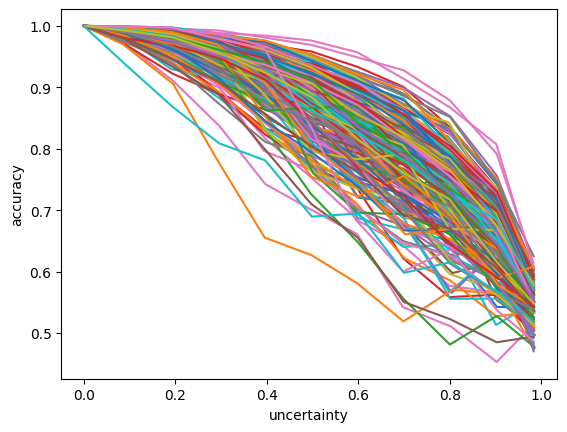

In [33]:
for i in range(len(ind_bin_accuracies)):
    plt.plot(ind_bin_uncertainty[i], ind_bin_accuracies[i])
    # if i == 100:
    #     break
plt.xlabel("uncertainty")
plt.ylabel("accuracy")

In [35]:
total_errors = []
volumes = []
error_ents = []

for i in tqdm(range(len(means)), position=0, leave=True):
    ent_map = ent_maps[i].cuda() * (1/(-math.log(0.5)))
    pred = means[i].cuda().argmax(dim=1)
    errors = pred != ys[i][0].cuda()
    volume = pred.sum().item()
    avg_error_ent = ent_map[errors].mean().item()
    
    total_errors.append(errors.sum().item())
    volumes.append(volume)
    error_ents.append(avg_error_ent)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 173.95it/s]


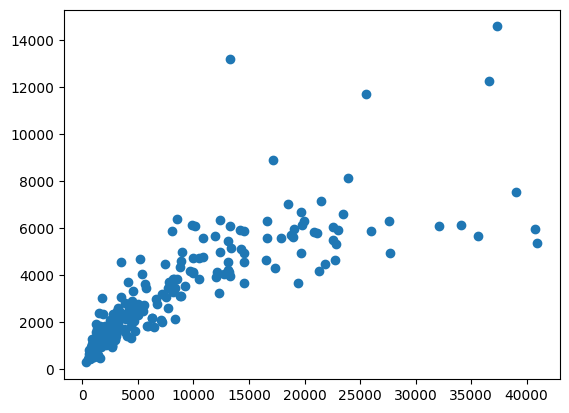

In [36]:
plt.scatter(volumes, total_errors)

Text(0, 0.5, 'Mean Uncertainty of Incorrect voxels')

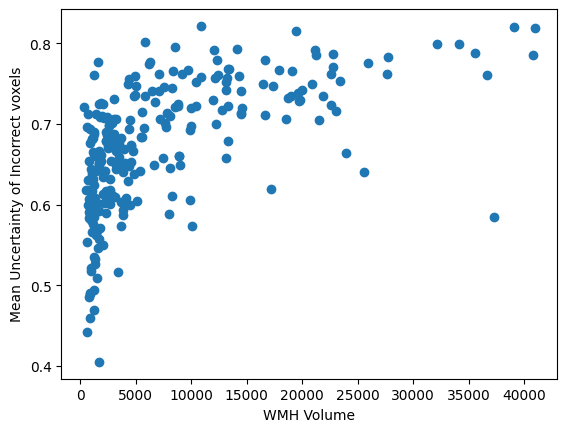

In [127]:
plt.scatter(volumes, error_ents)
#plt.xscale("log")
plt.xlabel("WMH Volume")
plt.ylabel("Mean Uncertainty of Incorrect voxels")

In [40]:
clin_values

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,WMH,PVWMH,DWMH,deepAtrophy,supAtrophy,BGPVS,CSPVS,relLes,oldLes,micrBld
0,4,CVD008,1,50.0,2,0,1,0.0,2.0,196.0,...,56.672922,2.0,3.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0
1,9,CVD014,1,74.0,1,0,1,0.0,0.0,138.0,...,19.852734,1.0,1.0,0.0,2.0,1.0,3.0,1.0,1.0,0.0
2,10,CVD016,1,87.0,1,0,1,0.0,0.0,165.0,...,77.187691,3.0,3.0,4.0,2.0,3.0,1.0,1.0,1.0,14.0
3,12,CVD018,1,77.0,2,0,1,1.0,0.0,179.0,...,28.363308,2.0,1.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0
4,16,CVD023,1,74.0,1,1,1,0.0,1.0,123.0,...,22.021616,3.0,2.0,4.0,4.0,3.0,2.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,CVD321,1,64.0,1,0,1,1.0,0.0,144.0,...,32.568750,3.0,1.0,3.0,2.0,1.0,2.0,1.0,1.0,0.0
246,246,CVD322,1,50.0,2,0,1,1.0,2.0,123.0,...,0.189844,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
247,247,CVD323,1,63.0,1,0,1,1.0,0.0,112.0,...,18.000000,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0
248,248,CVD324,1,63.0,1,0,1,1.0,0.0,170.0,...,33.626953,1.0,3.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0


In [41]:
from sklearn.decomposition import PCA

In [119]:
pca_df = clin_values.copy()
pca_df['color'] = uncert_mass - (wmh_mass * 0.69)

In [120]:
pca_df = preprep_clinscores(
    df=pca_df,
    fields=['sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld', 'color'
           ],
    inc_brain_scores=True,
    nan_filter_dict = {'hyperlipidaemia': 'row', 'smoking':'row', 'SBP':'col', 'DBP':'col', 'MMSE':'col', 'relLes':'row', 'ICV':'row', 'totalChl': 'col', 'micrBld': 'row'},
    other_fields_policy = 'row',#'col',
    relLes_default = 0,
    one_hot_fields = ['sbjGroup', 'smoking', 'PVWMH', 'DWMH'],
    remove_one_hot_originals = False,
    log_fields = None,
    normalize_fields = ['age', 'ICV'],
    convert_strokeLes=True
)

color = pca_df['color']
pca_df = pca_df.drop(columns=['color'], inplace=False)

[1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1.]


In [121]:
pca = PCA(n_components=2)
result = pca.fit_transform(pca_df)

In [122]:
print(pca.explained_variance_ratio_)

[0.97057425 0.01181848]


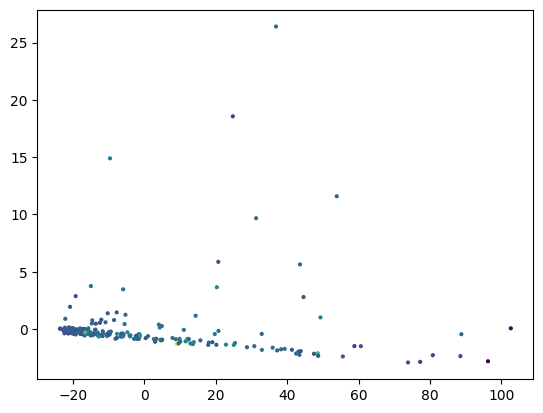

In [124]:
plt.scatter(result[:,0], result[:,1], c=color, label=color, s=4)

In [125]:
color

0       4036.427734
1       3593.472168
2       3649.371094
3      21032.371094
4       3623.140625
           ...     
216     4182.783691
217     1450.276123
218     4395.822754
219     5726.704590
220      643.518066
Name: color, Length: 221, dtype: float32